In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from linares_plot import *
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
import scipy
from scikits.bootstrap import ci 
from scipy.stats import norm
import matplotlib.mlab as mlab


c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62'
c_d0='grey'
c_d3 = '#91cf60'
boots =10


#data_psychophysics_corrected
data = pd.read_csv('C:\\Users\\David\\Dropbox\\IDIBAPS\\my code\\Project 1 (master thesis)\\idibaps_psychophysics')
df=data.loc[(data['type']==1) | (data['type']==2)]

In [2]:
print(len(df))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(df.loc[i,'A_T'], df.loc[i,'A_R'], df.loc[i,'r_T'], df.loc[i,'r_R']),3) for i in df.index]
df['modules']=modules


from pandas import concat
frames=[]
for group_label in df.subject.unique():
    sub_group=df.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2))  + 'cm')
    


df = concat(frames)
print(len(df))

### Distribution A_Err in cw-ccw
# sns.distplot(df['A_err'], kde=False)
# plt.title('Distribution Angle error')
# plt.legend(frameon=False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.gca().get_yaxis().tick_left()
# plt.xlabel('Angle error (Target-Response)')
# plt.show()

scipy.stats.normaltest(df['A_err'])

2403
Outliers in 1 = 2, limit=3.79cm
Outliers in 2 = 4, limit=2.92cm
Outliers in 3 = 5, limit=3.18cm
Outliers in 4 = 1, limit=2.81cm
Outliers in 5 = 9, limit=2.41cm
Outliers in 6 = 6, limit=5.03cm
Outliers in 7 = 6, limit=3.33cm
Outliers in 8 = 7, limit=2.93cm
Outliers in 9 = 7, limit=3.96cm
Outliers in 10 = 4, limit=4.12cm
Outliers in 11 = 6, limit=4.49cm
Outliers in 12 = 4, limit=3.21cm
Outliers in 13 = 7, limit=3.33cm
Outliers in 14 = 5, limit=3.59cm
Outliers in 15 = 4, limit=3.5cm
Outliers in 16 = 4, limit=4.16cm
Outliers in 17 = 8, limit=3.32cm
Outliers in 18 = 7, limit=4.54cm
2307


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NormaltestResult(statistic=18.13955562885638, pvalue=0.0001150921076113315)

In [3]:
## Functions to use

def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def get_quadrant(angle): 
    #angle in degrees, return the quadrant which it belongs to
    if angle>=0 and angle<=90:
        Q=1
    elif angle>90 and angle<=180:
        Q=2
    elif angle>180 and angle<=270:
        Q=3
    elif angle>270 and angle<=360:
        Q=4
    
    return Q


def cw_ccw_detector(target, NT):
    #print [target, NT,get_quadrant(target),get_quadrant(NT) ]
    #it returns the relative position of the target respect the NT
    if abs(target-NT)<180:
        if target<NT: 
            o='cw'
        else: 
            o='ccw'
    else:
        if target<NT: 
            o='ccw'
        else: 
            o='cw'
    #Ecceptions
    if [get_quadrant(target),get_quadrant(NT) ] == [1,4] : o= 'ccw'
    if [get_quadrant(target),get_quadrant(NT) ] == [4,1] : o= 'cw'
    
    return o



In [4]:
#Add necessary column
orients=[]
for i in range(0, len(df)):
    orients.append(cw_ccw_detector(df['A_T'].iloc[i], df['A_NT'].iloc[i]))

    
df['cw_ccw']=orients
df['dist_T_NT']=abs(df['A_T']-df['A_NT'])

In [5]:
##### DISTANCE TO MEAN OF CW AND CCW as a measure
means_cw={}

for Subj in df.subject.unique():
    d_subj = df.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for distance in df.dist_T_NT.unique():
            for radius in df.r_T.unique():
                for delay in df.delay.unique():
                    mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['r_T']==radius)
                                               & (d_subj['dist_T_NT']==distance) & (d_subj['delay']==delay) ,'A_err'].mean(), 3)
                    
                    means_cw[str(Subj)  + '_' + str(radius) + '_' +str(distance) +'_'+ str(delay) + '_' +ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df.index:
    or_ = df.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df.loc[i, 'subject'])+ '_' + str(df.loc[i, 'r_T']) + '_' +str(df.loc[i, 'dist_T_NT']) +'_' +str(df.loc[i, 'delay']) +'_'  + or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append(df.loc[i, 'A_err'] - means_cw[idx] )  
    elif or_ =='cw':
        cw_ccw_distance.append( means_cw[idx] - df.loc[i, 'A_err'])  
    else:
        print('Error')
    


df['distance_A_err'] = np.array(cw_ccw_distance)/2
print(len(df))

#Remove null
df=df[~df['distance_A_err'].isnull()]
print(len(df))

2307
2291


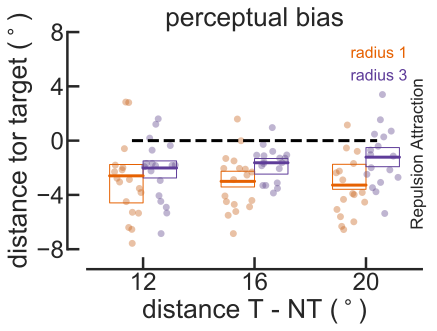

p_values:  12: 0.09205, 14: 0.00001, 20: 0.00000 
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 1169    Method:             REML          
No. Groups:       18      Scale:              6.7009        
Min. group size:  16      Likelihood:         -2806.6805    
Max. group size:  98      Converged:          Yes           
Mean group size:  64.9                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.388    1.452  0.267 0.789 -2.457  3.233
r_T               -0.275    0.127 -2.161 0.031 -0.524 -0.026
dist_T_NT         -0.329    0.086 -3.820 0.000 -0.497 -0.160
r_T:dist_T_NT      0.031    0.008  3.991 0.000  0.016  0.046
Group Var          2.519    0.349                           



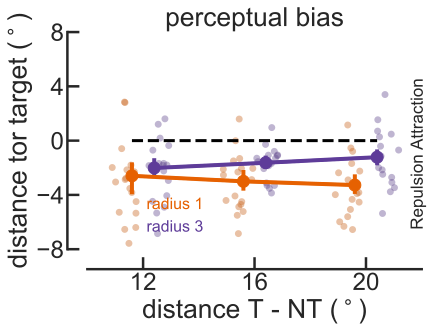

In [6]:
###Linares plot box

plt.figure()
linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject', 
             reps=boots)
plt.plot([-0.1,2.1], [0,0], 'k--');
plt.ylim(-8,4);
plt.title('perceptual bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance tor target ($^\circ$)');
plt.yticks([-8, -4, 0, 4, 8]);
l = plt.legend(loc=1, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(2.4, 3.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -1.9, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()




### TTESTS

df_d0 = df.loc[df['delay']==0]

p_values=[]

for dist in [12, 16, 20]:
    a= df_d0[(df_d0['r_T'] == 7.72 ) & (df_d0['dist_T_NT'] == dist) ]['distance_A_err']
    b= df_d0[(df_d0['r_T'] == 13.68 ) & (df_d0['dist_T_NT'] == dist) ]['distance_A_err']
    p_values.append(ttest_ind(a,b)[1])


print(r'p_values:  12: %.5f, 14: %.5f, 20: %.5f ' %(p_values[0], p_values[1], p_values[2]))
#print(p_values)

#### MODEL
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT', data=df_d0, groups=df_d0['subject']).fit()
print(res_m.summary())




###Linares plot line
plt.figure()
linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject',
            plot_box='line', reps=boots)
plt.plot([-0.1,2.1], [0,0], 'k--');
plt.ylim(-8,4);
plt.title('perceptual bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance tor target ($^\circ$)');
plt.yticks([-8, -4, 0, 4, 8]);
l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(2.4, 3.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -1.9, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()





In [7]:
#### MODEL
df_d0 = df.loc[df['delay']==0]
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT', data=df_d0, groups=df_d0['subject']).fit()
print(res_m.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 1169    Method:             REML          
No. Groups:       18      Scale:              6.7009        
Min. group size:  16      Likelihood:         -2806.6805    
Max. group size:  98      Converged:          Yes           
Mean group size:  64.9                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.388    1.452  0.267 0.789 -2.457  3.233
r_T               -0.275    0.127 -2.161 0.031 -0.524 -0.026
dist_T_NT         -0.329    0.086 -3.820 0.000 -0.497 -0.160
r_T:dist_T_NT      0.031    0.008  3.991 0.000  0.016  0.046
Group Var          2.519    0.349                           



In [8]:
# res_m = smf.mixedlm(formula='Int_A_err ~ r_T * dist_T_NT', data=df_d0, groups=df_d0['subject']).fit()
# print(res_m.summary())

In [9]:
## Mixed model (subject as random intercept)
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT*delay', data=df, groups=df['subject']).fit()
print(res_m.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: distance_A_err
No. Observations:   2291    Method:             REML          
No. Groups:         18      Scale:              9.6171        
Min. group size:    31      Likelihood:         -5893.2175    
Max. group size:    191     Converged:          Yes           
Mean group size:    127.3                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.413    1.716  0.241 0.810 -2.950  3.777
r_T                 -0.276    0.152 -1.814 0.070 -0.575  0.022
dist_T_NT           -0.331    0.103 -3.210 0.001 -0.533 -0.129
r_T:dist_T_NT        0.031    0.009  3.344 0.001  0.013  0.050
delay               -2.572    0.796 -3.231 0.001 -4.133 -1.012
r_T:delay            0.243    0.072  3.349 0.001  0.101  0.385
dist_

In [10]:
## Mixed model (subject as random intercept)
# res_m = smf.mixedlm(formula='Int_A_err ~ r_T * dist_T_NT*delay', data=df, groups=df['subject']).fit()
# print(res_m.summary())

In [11]:
#Measure d3-d0

d0={}

for Subj in df.subject.unique():
    d_subj = df.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for distance in df.dist_T_NT.unique():
            for radius in df.r_T.unique():
                mean_d0 = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['r_T']==radius)
                                           & (d_subj['dist_T_NT']==distance) & (d_subj['delay']==0) ,'distance_A_err'].mean(), 3)

                d0[str(Subj)  + '_' + str(radius) + '_' +str(distance) + '_' +ori] = mean_d0



dist_A_err_d3_d0=[]

for i in df.index:
    idx =  str(df.loc[i, 'subject'])+ '_' + str(df.loc[i, 'r_T']) + '_' +str(df.loc[i, 'dist_T_NT']) +'_'  + df.loc[i, 'cw_ccw']
    #
    dist_A_err_d3_d0.append(df.loc[i, 'distance_A_err'] - d0[idx] )

    


df['dist_A_err_d3_d0'] = dist_A_err_d3_d0

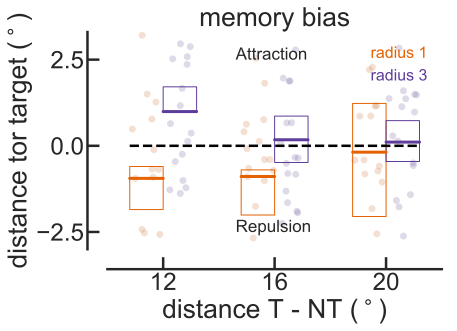

p_values:  12: 0.00001, 14: 0.01229, 20: 0.49686 
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dist_A_err_d3_d0
No. Observations: 1122    Method:             REML            
No. Groups:       18      Scale:              11.5932         
Min. group size:  15      Likelihood:         -2987.4482      
Max. group size:  93      Converged:          Yes             
Mean group size:  62.3                                        
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -7.839     1.874  -4.182  0.000  -11.512  -4.165
r_T             0.739     0.170   4.346  0.000    0.406   1.073
dist_T_NT       0.361     0.114   3.153  0.002    0.136   0.585
r_T:dist_T_NT  -0.035     0.010  -3.342  0.001   -0.055  -0.014
Group Var       0.679     0.092                                



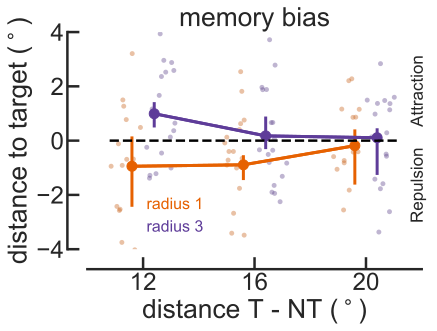

In [12]:

linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.2, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=7,  by_subj=True, subj_col='subject',
              plot_box=True, reps=boots)

plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.title('memory bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance tor target ($^\circ$)');
plt.yticks([ -5, -2.5,  0, 2.5, 5]);
plt.ylim(-3,3.3);
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(0.65, 2.5, 'Attraction', fontsize=17);
plt.text(0.65, -2.5, 'Repulsion', fontsize=17);
plt.show()



## pvalues
p_values=[]
for dist in [12, 16, 20]:
    a= df[(df['r_T'] == 7.72 ) & (df['dist_T_NT'] == dist) ]['dist_A_err_d3_d0']
    b= df[(df['r_T'] == 13.68 ) & (df['dist_T_NT'] == dist) ]['dist_A_err_d3_d0']
    p_values.append(ttest_ind(a,b)[1])

#print(p_values)
print(r'p_values:  12: %.5f, 14: %.5f, 20: %.5f ' %(p_values[0], p_values[1], p_values[2]))


#### MODEL
res_m = smf.mixedlm(formula='dist_A_err_d3_d0 ~ r_T * dist_T_NT', data=df.loc[df['delay']==3], groups=df.loc[df['delay']==3, 'subject']).fit()
print(res_m.summary())



###linares plot line
linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=5,  
             by_subj=True, subj_col='subject',
              plot_box='line', LW=3, MS=10, reps=boots)

plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.title('memory bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance to target ($^\circ$)');
plt.yticks([ -4, -2,  0, 2, 4]);
plt.ylim(-4,4);
l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(2.4, 2.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -0.7, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()




C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

-2.593139303482587
-2.0154921465968587
-0.9444400000000001
0.9920416666666666


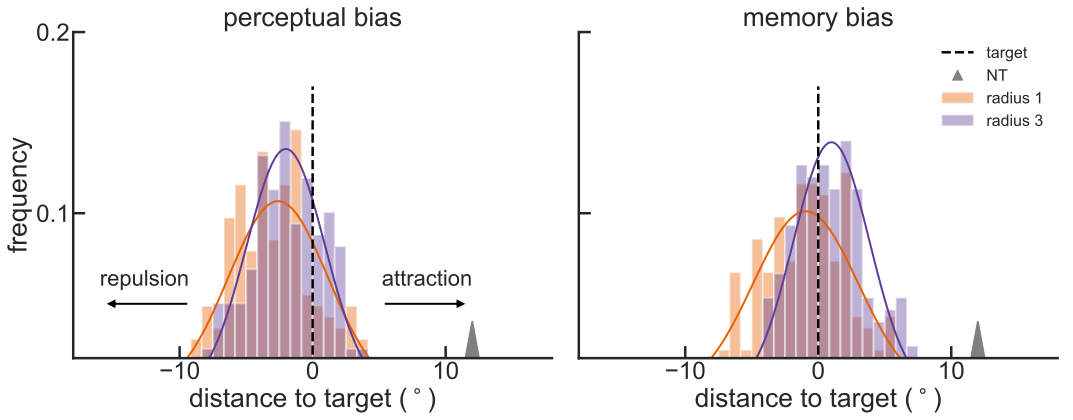

In [13]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


plt.subplot(121)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'distance_A_err'] , bins=np.linspace(-10,10,25), 
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'distance_A_err'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3,ax=ax)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-18,18)
plt.ylim(0.02)
plt.yticks([0.1,0.2])
#plt.plot([12, 12], [0,0.17], color='grey', linestyle='-', linewidth=2.5, label='NT');
plt.plot((12,10), "^", color='grey', markersize=10, label='NT');

#l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.text(5.2, 0.06, 'attraction', fontsize=22);
plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay0')
plt.title('perceptual bias')
plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');

plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');


pts = [(11, 0), (12, 0.04), (13, 0)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax.add_patch(triangle)


print(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'distance_A_err'].mean())
print(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'distance_A_err'].mean())


plt.subplot(122)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax2)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3, ax=ax2)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-18,18)
plt.ylim(0.02)
plt.yticks([0.1,0.2])

##triangulo locura
plt.plot((12,10), "^", color='grey', markersize=10, label='NT');



l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('')
#plt.text(5.2, 0.06, 'attraction', fontsize=22);
#plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0.1,0.2], ['', ''])

plt.title('memory bias')
# plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='left', verticalalignment='bottom');

# plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
#            horizontalalignment='left', verticalalignment='bottom');



pts = [(11, 0), (12, 0.04), (13, 0)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)


plt.tight_layout()


print(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'dist_A_err_d3_d0'].mean())
print(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'dist_A_err_d3_d0'].mean())


In [14]:
df_cont=data.loc[data['type']==0]
print(len(df_cont))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(df_cont.loc[i,'A_T'], df_cont.loc[i,'A_R'], df_cont.loc[i,'r_T'], df_cont.loc[i,'r_R']),3) for i in df_cont.index]
df_cont['modules']=modules


from pandas import concat
frames=[]
for group_label in df_cont.subject.unique():
    sub_group=df_cont.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2)) )
    


df_cont = concat(frames)
print(len(df_cont))

df_cont['abs_err']=abs(df_cont['A_err'].copy())

### Distribution A_Err in cw-ccw
# sns.distplot(df_cont['A_err'], kde=False)
# plt.title('Distribution Angle error')
# plt.legend(frameon=False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.gca().get_yaxis().tick_left()
# plt.xlabel('Angle error (Target-Response)')
# plt.show()

3396
Outliers in 1 = 2, limit=2.81
Outliers in 2 = 8, limit=2.66
Outliers in 3 = 2, limit=4.03
Outliers in 4 = 1, limit=2.67
Outliers in 5 = 6, limit=2.33
Outliers in 6 = 5, limit=4.51
Outliers in 7 = 7, limit=2.53
Outliers in 8 = 10, limit=2.48
Outliers in 9 = 7, limit=3.48
Outliers in 10 = 10, limit=3.76
Outliers in 11 = 6, limit=4.06
Outliers in 12 = 2, limit=3.48
Outliers in 13 = 9, limit=2.41
Outliers in 14 = 9, limit=3.31
Outliers in 15 = 9, limit=2.46
Outliers in 16 = 11, limit=2.49
Outliers in 17 = 10, limit=2.79
Outliers in 18 = 7, limit=3.79
3275


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


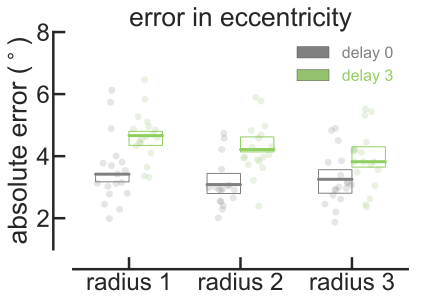

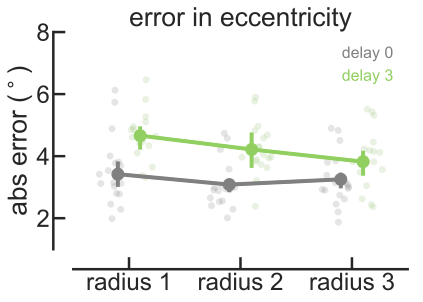

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_err   
No. Observations: 3275    Method:             REML      
No. Groups:       18      Scale:              7.7495    
Min. group size:  70      Likelihood:         -8030.0091
Max. group size:  230     Converged:          Yes       
Mean group size:  181.9                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.577    0.348 10.283 0.000  2.895  4.258
r_T           -0.028    0.028 -0.998 0.318 -0.083  0.027
delay          0.730    0.146  4.995 0.000  0.443  1.016
r_T:delay     -0.038    0.013 -2.825 0.005 -0.064 -0.012
Group Var      0.484    0.065                           



In [15]:


linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', reps=boots)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'absolute error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
plt.show()


linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=boots)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.show()


### Model
res_m = smf.mixedlm(formula='abs_err ~ r_T*delay ', data=df_cont, groups=df_cont['subject']).fit()
print(res_m.summary())
             
             

In [16]:

res_m = smf.mixedlm(formula='abs_err ~ r_T ',data=df_cont.loc[df_cont['delay']==0], groups=df_cont.loc[df_cont['delay']==0, 'subject']).fit()
print(res_m.summary())

res_m = smf.mixedlm(formula='abs_err ~ r_T ',data=df_cont.loc[df_cont['delay']==3], groups=df_cont.loc[df_cont['delay']==3, 'subject']).fit()
print(res_m.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_err   
No. Observations: 1680    Method:             REML      
No. Groups:       18      Scale:              5.8426    
Min. group size:  36      Likelihood:         -3889.6237
Max. group size:  119     Converged:          Yes       
Mean group size:  93.3                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.575    0.321 11.139 0.000  2.946  4.204
r_T           -0.028    0.024 -1.143 0.253 -0.075  0.020
Group Var      0.574    0.091                           

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_err   
No. Observations: 1595    Method:             REML      
No. Groups:       18      Scale:              9.7507    
Min. group size:  34      Likelihood:         -409

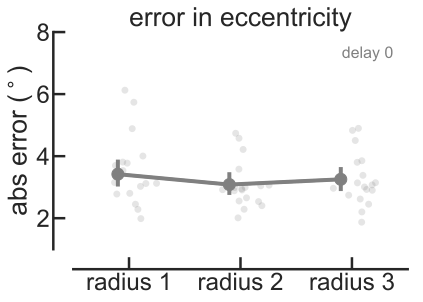

In [17]:
linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=1000)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
#l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
#l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
#l.legendHandles[1].set_visible(False);
plt.show()

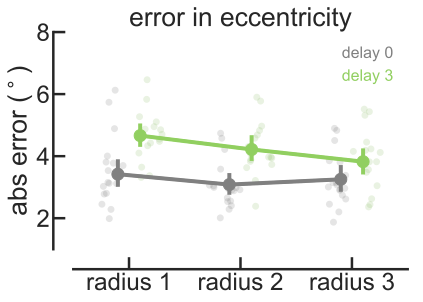

In [18]:
linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0, 3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=1000)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.show()

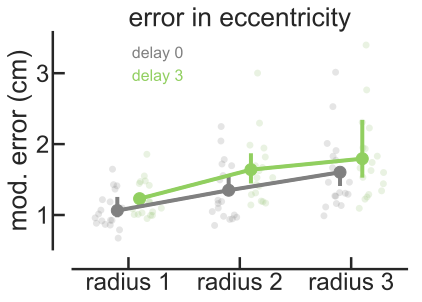

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: modules   
No. Observations: 3275    Method:             REML      
No. Groups:       18      Scale:              0.4122    
Min. group size:  70      Likelihood:         -3245.9661
Max. group size:  230     Converged:          Yes       
Mean group size:  181.9                                 
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  0.361     0.115   3.125  0.002   0.134   0.587
r_T        0.091     0.006  14.044  0.000   0.078   0.103
delay      0.052     0.034   1.537  0.124  -0.014   0.118
r_T:delay  0.002     0.003   0.594  0.553  -0.004   0.008
Group Var  0.150     0.081                               



In [19]:
linares_plot(x='r_T', y='modules', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=10)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'mod. error (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
#plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.show()


### Model
res_m = smf.mixedlm(formula='modules ~ r_T*delay ', data=df_cont, groups=df_cont['subject']).fit()
print(res_m.summary())

In [20]:
res_m = smf.mixedlm(formula='modules ~ r_T ', data=df_cont.loc[df_cont['delay']==0], groups=df_cont.loc[df_cont['delay']==0, 'subject']).fit()
print(res_m.summary())


res_m = smf.mixedlm(formula='modules ~ r_T ', data=df_cont.loc[df_cont['delay']==3], groups=df_cont.loc[df_cont['delay']==3, 'subject']).fit()
print(res_m.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: modules   
No. Observations: 1680    Method:             REML      
No. Groups:       18      Scale:              0.3846    
Min. group size:  36      Likelihood:         -1617.1142
Max. group size:  119     Converged:          Yes       
Mean group size:  93.3                                  
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  0.360     0.111   3.253  0.001   0.143   0.576
r_T        0.091     0.006  14.535  0.000   0.078   0.103
Group Var  0.136     0.078                               

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: modules   
No. Observations: 1595    Method:             REML      
No. Groups:       18      Scale:              0.4342    
Min. group size:  34      Likelihood:       

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


4.269036817547959 4.038356207778243
5.739686869140978 4.695789796863413


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


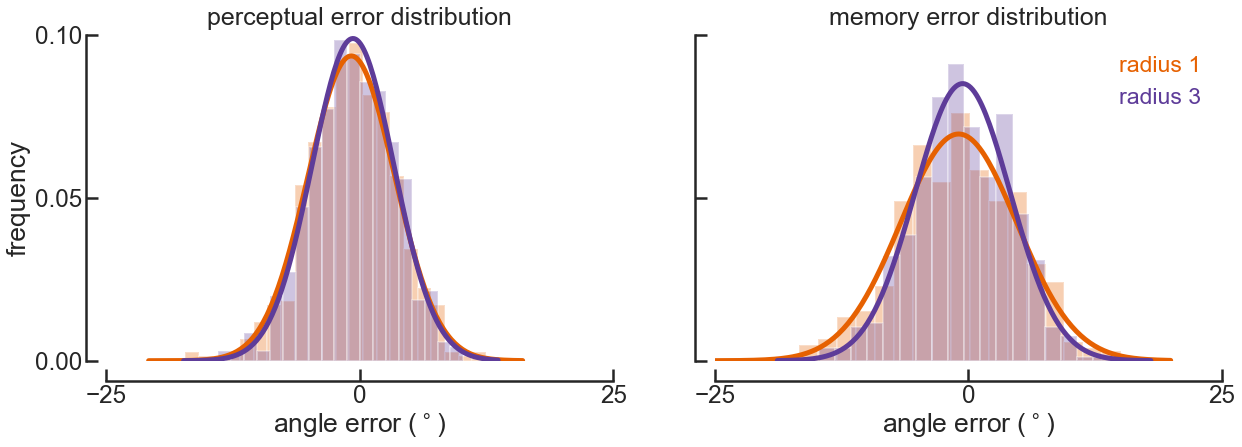

In [21]:
%config InlineBackend.figure_format = 'png'

### Figure paper
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


plt.subplot(121)

# read data from a text file. One number per line
datos_d0_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==0)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d0_r1)
datos_d0_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==0)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d0_r3)
print(sigma_r1, sigma_r3)

sns.distplot(datos_d0_r1, color= c_r1, fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':5}, ax=ax, hist_kws={'alpha':0.3})
sns.distplot(datos_d0_r3, color=c_r3, fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':5}, ax=ax, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('frequency')
#plt.title(r'$\mathrm{Delay=0:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('perceptual error distribution',  fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
adjust_spines(plt.gca(), ['left', 'bottom'])



plt.yticks([0, 0.05,0.1])
plt.xticks([-25, 0, 25])
plt.legend(frameon=False)
plt.ylim(0,0.1)
plt.xlim(-25,25)


plt.subplot(122)

# read data from a text file. One number per line
datos_d3_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==3)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d3_r1)
datos_d3_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==3)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d3_r3)
print(sigma_r1, sigma_r3)


sns.distplot(datos_d3_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5}, ax=ax2, hist_kws={'alpha':0.3})
sns.distplot(datos_d3_r3, color=c_r3, fit=norm, kde=False, label='radius 3', fit_kws={"color":c_r3, 'linewidth':5},  ax=ax2, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('memory error distribution', fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0,0.05,0.1], ['', ''])
plt.xticks([-25, 0, 25])


plt.ylim(0,0.1)
plt.xlim(-25,25)

adjust_spines(plt.gca(), ['left', 'bottom'])


l = plt.legend(loc=1, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


# Modeling

In [22]:
df_mm = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please.xlsx')
print(len(df_mm))
df_mm=df_mm.loc[df_mm['success']==True]
df_b1 = df_mm[['b1', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b1.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']
df_b2 =df_mm[['b2','decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b2.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']


4600


In [23]:
df_c = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_close.xlsx')
print(len(df_c))
df_c=df_c.loc[df_c['success']==True]
df_b3 = df_c[['b1', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b3.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']
df_b4 =df_c[['b2','decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b4.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']

1200


In [24]:
df_model=pd.concat([df_b1, df_b2, df_b3, df_b4])
len(df_model)/2

4116.0

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


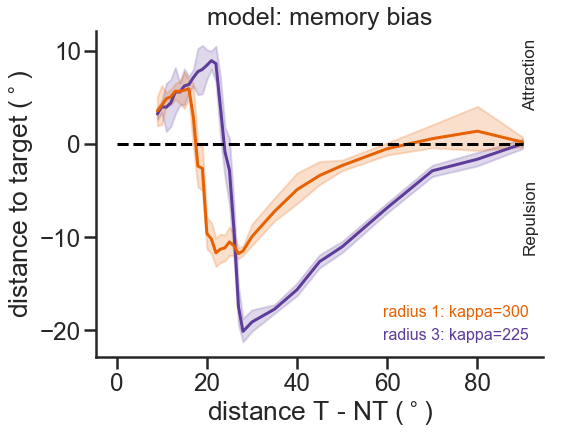

In [25]:
plt.figure(figsize=(8,6))
g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model) 
plt.plot([0, max(df_model['separation'])], [0,0], 'k--') 
plt.title('model: memory bias', fontsize=25) #condition title
plt.gca().spines['right'].set_visible(False) #no right axis
plt.gca().spines['top'].set_visible(False) #no  top axis
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
l = plt.legend(loc=4, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('');
l.get_texts()[1].set_text('radius 1: kappa=300');
l.get_texts()[1].set_color(c_r1);
l.get_texts()[2].set_text('radius 3: kappa=225');
l.get_texts()[2].set_color(c_r3);
l.legendHandles[1].set_visible(False);
l.legendHandles[2].set_visible(False);
plt.text(90, 10, 'Attraction', fontsize=17, rotation='vertical');
plt.text(90, -5, 'Repulsion', fontsize=17, rotation='vertical');
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance to target ($^\circ$)');
plt.show(block=False)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


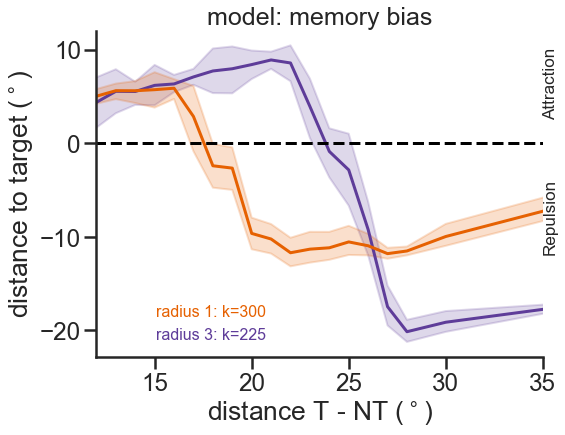

In [26]:
plt.figure(figsize=(8,6))
g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model) 
plt.plot([0, max(df_model['separation'])], [0,0], 'k--') 
plt.title('model: memory bias', fontsize=25) #condition title
plt.gca().spines['right'].set_visible(False) #no right axis
plt.gca().spines['top'].set_visible(False) #no  top axis
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
# plt.legend(title='kappaE', loc='upper right', labels=[str(i) for i in [225, 300]], frameon=False )
l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('');
l.get_texts()[1].set_text('radius 1: k=300');
l.get_texts()[1].set_color(c_r1);
l.get_texts()[2].set_text('radius 3: k=225');
l.get_texts()[2].set_color(c_r3);
l.legendHandles[1].set_visible(False);
l.legendHandles[2].set_visible(False);
plt.xlim(12, 35)
plt.text(35, 9, 'Attraction', fontsize=17, rotation='vertical');
plt.text(35, -5, 'Repulsion', fontsize=17, rotation='vertical');
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance to target ($^\circ$)');
plt.show(block=False)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


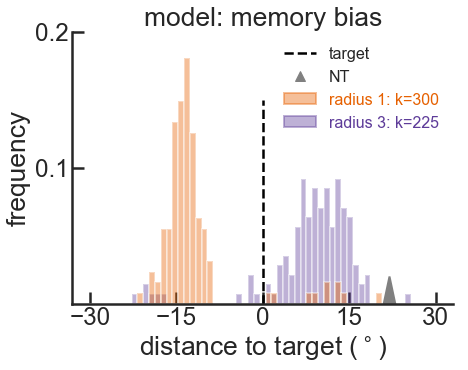

In [27]:
values_225 = df_model.loc[(df_model['separation']==22) & (df_model['kappas_E']==225) , 'bias']
values_300 =  df_model.loc[(df_model['separation']==22) & (df_model['kappas_E']==300) , 'bias']
#values_225 = values_225*12/22
#values_300 = values_300*12/22


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.plot([0, 0], [0,0.15], 'k--', linewidth=2.5, label='target');
plt.plot((700), "^", color='grey', markersize=10, label='NT');

sns.distplot(values_225, color=c_r3, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
              label='radius 3', fit_kws={"color":c_r3, 'linewidth':0}, ax=ax2)
sns.distplot(values_300,  color=c_r1, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
             label='radius 1', fit_kws={"color":c_r1, 'linewidth':0}, ax=ax2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
#plt.text(8, 60, 'attraction', fontsize=22);
#plt.text(-10, 60, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0.1,0.2, 0.3])
plt.xticks([-30, -15, 0, 15, 30])
plt.xlim(-33, 33)
plt.ylim(0,0.2)
l = plt.legend(loc=1, frameon=False, prop={'size': 16})
l.get_texts()[2].set_text('radius 1: k=300');
l.get_texts()[2].set_color(c_r1);
l.get_texts()[3].set_text('radius 3: k=225');
l.get_texts()[3].set_color(c_r3);
l.legendHandles[2].set_color(c_r1);
l.legendHandles[3].set_color(c_r3);


pts = [(21, 0.), (22, 0.02), (23, 0.)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)

plt.title('model: memory bias')

f.delaxes(ax)


plt.show()

In [28]:
print(np.mean(values_225), np.mean(values_300))

8.59511295864654 -11.694296265156446


In [29]:
df_1_a1 = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_11.xlsx')
df_1_a2 = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_12.xlsx')

df_1=pd.concat([df_1_a1, df_1_a2])
print(len(df_1))
df_1 = df_1.loc[df_1['success']==True]
df_1 = df_1[abs(df_1.b2)<1.5*np.std(df_1.b2)]

df_1['abs_bias']=abs(df_1['b2'])
print(len(df_1))

4000
3275


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Radius 1 std: 4.476651253211916
Radius 3 std: 3.8784295130895377

Total number of succes simul: 3275


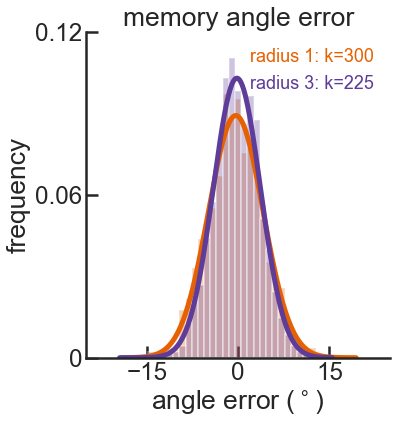

In [30]:

f = plt.figure(figsize=(12,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)

sns.distplot(df_1.loc[df_1['kappas_E']==300, 'b2'], color=c_r1,  bins=np.linspace(-30,30,60),
             label='radius 1', kde=False, fit=norm,  fit_kws={"color":c_r1, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax)

sns.distplot(df_1.loc[df_1['kappas_E']==225, 'b2'], color=c_r3,  bins=np.linspace(-30,30,60),
             label='radius 3', kde=False, fit=norm,  fit_kws={"color":c_r3, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax)



plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
plt.title('memory angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0, 0.06,  0.12], [0, 0.06, 0.12])
plt.xticks([-15, 0, 15])
plt.ylim(0,0.12)
plt.xlim(-25,25)
plt.ylabel('frequency')

l = plt.legend(loc=1, frameon=False, prop={'size': 18})
l.get_texts()[0].set_text('radius 1: k=300');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3: k=225');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

f.delaxes(ax2)

from scipy.stats import norm
mu, std = norm.fit(df_1.loc[df_1['kappas_E']==300, 'b2'])
print('Radius 1 std: ' +str(std) ) 
mu, std = norm.fit(df_1.loc[df_1['kappas_E']==225, 'b2'])
print('Radius 3 std: ' +str(std) ) 

print('')

print( 'Total number of succes simul: ' + str(len(df_1.loc[df_1['kappas_E']==300]) + len(df_1.loc[df_1['kappas_E']==225]) ) )

In [31]:
res_m = smf.ols(formula='abs_bias ~ kappas_E', data=df_1).fit()
print(res_m.summary())

                            OLS Regression Results                            
Dep. Variable:               abs_bias   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     32.66
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           1.20e-08
Time:                        10:59:32   Log-Likelihood:                -7748.3
No. Observations:                3275   AIC:                         1.550e+04
Df Residuals:                    3273   BIC:                         1.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5070      0.322      4.683      0.0

In [32]:
df_fg = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_fit_gauss.xlsx')
print(len(df_fg))
df_fg=df_fg.loc[df_fg['success']==True]
print(len(df_fg))
df_fg = df_fg[abs(df_fg.gaussian_std)<1.5*np.std(df_fg.gaussian_std)]
df_fg = df_fg[df_fg.gaussian_std>0]


100
79


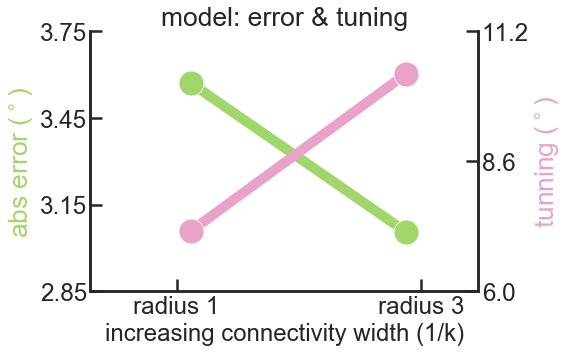

In [33]:
plt.figure(figsize=(8,5))

c_tuning= '#e9a3c9'
c_error = '#a1d76a'

ax = sns.lineplot( x="kappas_E", y="abs_bias", ci=None, data=df_1, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_error) 
plt.ylim(2.85, 3.75)
plt.yticks([2.85, 3.15, 3.45, 3.75])
plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['top'].set_visible(False)
plt.tick_params(direction='in')
plt.xlabel('')
plt.xlim(200, 335)
plt.gca().invert_xaxis()
plt.xlabel('increasing connectivity width (1/k)', fontsize=24)
ax.yaxis.label.set_color(c_error)

ax2 = ax.twinx()
df_fg['gaussian_std_deg'] = df_fg['gaussian_std']*180/np.pi
ax = sns.lineplot( x="kappas_E", y="gaussian_std_deg", ci=None, data=df_fg, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_tuning, ax=ax2) 

plt.ylim(6,11.2)
plt.yticks([6,8.6,11.2])
plt.gca().spines['top'].set_visible(False)
plt.ylabel(r'tunning ($^\circ$)')
plt.tick_params(direction='in')
plt.xlabel('increasing connectivity width (1/k)', fontsize=24)
plt.xticks([305, 220], ['radius 1','radius 3'], rotation=45)
ax.yaxis.label.set_color(c_tuning)


plt.title('model: error & tuning')
plt.tight_layout()
plt.show()

In [34]:
5.2/2

2.6

## Monkeys

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:119: InstabilityWarning: Some values used extremal samples; results are probably unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:119: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:119: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
No handles with labels found 

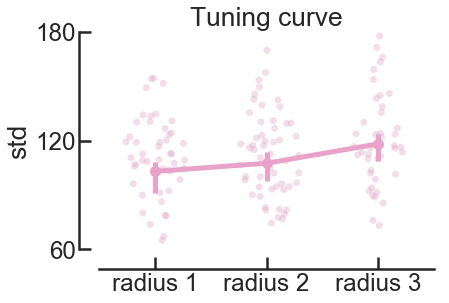

                            OLS Regression Results                            
Dep. Variable:         tuning_std_deg   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     5.862
Date:                Thu, 23 Jul 2020   Prob (F-statistic):             0.0167
Time:                        10:59:33   Log-Likelihood:                -737.46
No. Observations:                 153   AIC:                             1479.
Df Residuals:                     151   BIC:                             1485.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.4474      6.461     14.618      0.0

In [35]:
df_m = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\figures\\df_stds_monkeys.xlsx')
df_m['tuning_std_deg'] = df_m['tuning_std']*180/np.pi
c_tuning= '#e9a3c9'

linares_plot(x='radius', y='tuning_std_deg', order=[1,2,3], CI=0.95,
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=5, MS=10, reps=100)

plt.xlabel('')
plt.ylabel('std')
plt.title('Tuning curve')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.legend(frameon=False)
#plt.ylim(1.65, 2.2);
#plt.yticks([ 1.8, 2, 2.2]);
plt.gca().set_ylim( 60,180)
plt.gca().set_yticks([60,120, 180]);
plt.show()


model = smf.ols(formula="tuning_std_deg ~  radius", data=df_m).fit()
print(model.summary())




C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


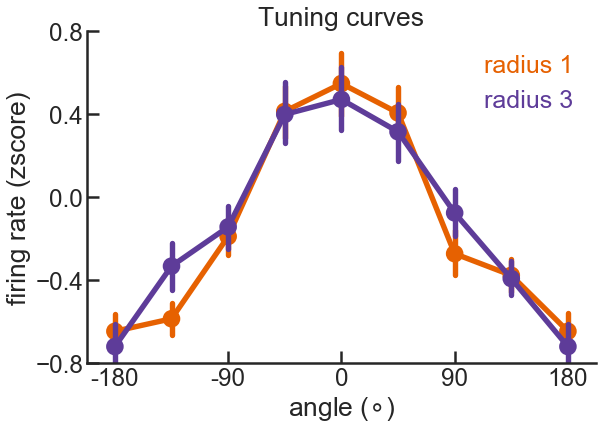

In [36]:
df_firings = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\figures\\df_norm_firings.xlsx')

c_tuning= '#e9a3c9'

c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62

sns.factorplot( x="angle", y="firing", data=df_firings, hue='radius', 
               palette=[c_r1, c_r3], ci=68, size=6, aspect=1.5, legend=False);

plt.xlabel(r'angle ($\circ$)');
plt.ylabel('firing rate (zscore)')
plt.title('Tuning curves')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xticks([ 0, 2, 4, 6, 8], [-180, -90, 0, 90, 180]);

l = plt.legend(loc=1, frameon=False, prop={'size': 25});
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

plt.ylim(-0.8, 0.8);
plt.yticks([ -0.8, -0.4, 0, 0.4, 0.8]);


In [37]:
df_m

,tuning_std,radius,tuning_std_deg
0,2.350575,1,134.678011
1,1.376253,1,78.853479
2,1.172411,1,67.174228
3,1.397194,1,80.053332
4,2.068878,1,118.537958
5,1.825035,1,104.566827
6,0.766934,1,43.942058
7,1.875557,1,107.461490
8,0.799226,1,45.792281
9,0.000000,1,0.000000


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:119: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:119: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).ge

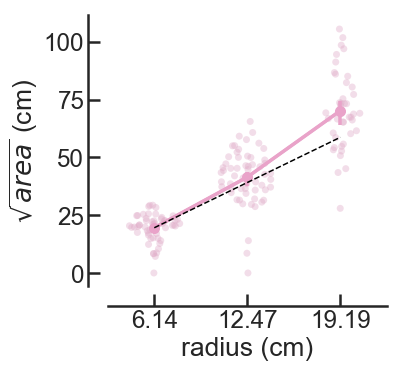

In [38]:
df_m['rad_std']=np.radians(df_m['tuning_std_deg']) ## the std is like the diameter of the tuning curve

r1cm = round(np.tan(np.radians(7))*50, 2)  # 50 is the distance to screen and 7 is the v.a of 1st radius 
r2cm = round(np.tan(np.radians(14))*50, 2)  
r3cm = round(np.tan(np.radians(21))*50, 2)  


df_m['rad_cm']=df_m['radius'].replace([1,2,3], [r1cm, r2cm, r3cm]) #replace radius by the real cm value
df_m['radio_']=df_m['rad_cm'] * df_m['rad_std'] ## get the diameter of the RF cm
df_m['area_']=np.sqrt( df_m['radio_']**2 * np.pi  ) ## comute the sqrt of the are (measure that is tipically used)


f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111)

plt.subplot(111)


linares_plot(x='rad_cm', y='area_', order=[r1cm, r2cm, r3cm], CI=0.95,
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=3.5, MS=10, reps=100)

plt.ylabel(r'$\sqrt{area}$ (cm)')
plt.xlabel(r'radius (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
#plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.legend(frameon=False)
#plt.ylim(1.65, 2.2);
#plt.yticks([ 1.8, 2, 2.2]);
#plt.gca().set_ylim( 60,180)
#plt.gca().set_yticks([60,120, 180]);

plt.gca().plot([0,1,2], 
               [df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean(), 
                df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean()*2, 
                df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean()*3   ], 'k--', linewidth=1.5, zorder=3)

#plt.ylim(0,100)
plt.show()

## Model currents

In [39]:
current_225 = np.loadtxt('current_225.txt')
current_300 = np.loadtxt('current_300.txt')
sep_deg=23
N=512
sep_neurons = sep_deg*len(current_225)/360
ref=np.zeros(N)
att_color = '#e9a3c9'
rep_color= '#a1d76a'

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


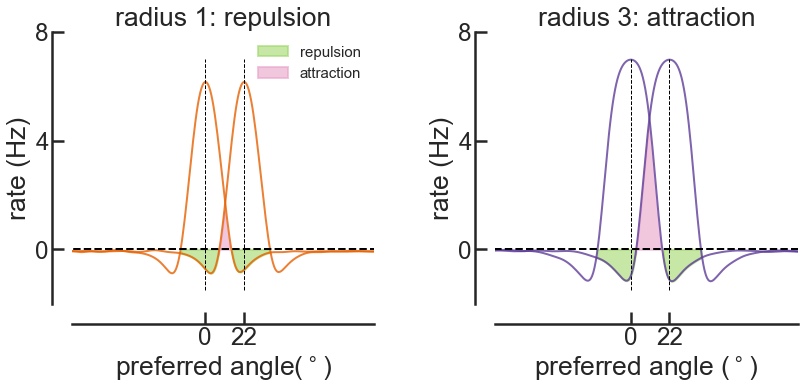

In [40]:
f = plt.figure(figsize=(13,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)

static = current_300
displaced= np.roll(current_300, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r1, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r1, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 1: repulsion')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[13:16]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


plt.subplot(122)

static = current_225
displaced= np.roll(current_225, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r3, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r3, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 3: attraction')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[5:8]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
#plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle ($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


plt.subplots_adjust(wspace=0.4)


30000
28566


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


                            OLS Regression Results                            
Dep. Variable:                  absb2   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     2233.
Date:                Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:59:43   Log-Likelihood:                -55190.
No. Observations:               28461   AIC:                         1.104e+05
Df Residuals:                   28457   BIC:                         1.104e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5853      0.152      3.852   

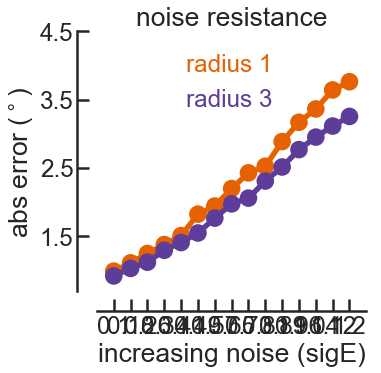

In [41]:
## visualize
# df__=pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_noise_increase.xlsx')
# df__ = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_noise_increase2.xlsx')

# df__ = pd.concat([df__, df__2])

df__ = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_noise_1000.xlsx')
print(len(df__))

df___=df__.loc[df__['success']==True] 
print(len(df___))
df___['absb2']=abs(df___.b2) 
df___ = df___[abs(df___.absb2)<2.5*np.std(df___.absb2)] 
###df___ = df___[abs(df___.absb2)<20]
##df___ = df___[abs(df___.absb2)<1.5*np.stad(df___.absb2)] ## more conservative (ideally, you shoud do the 2.5 std for each of the sigE tested)



#sns.factorplot(x='sigE', y='absb2', hue='kappas_E', ci=None, data=df_) 


c_tuning= '#e9a3c9'
g =sns.factorplot( x="sigE", y="absb2", hue='kappa_E', data=df___, palette=[c_r1, c_r3], hue_order=[300,225],
                  ci=None, size=5, aspect=1, legend=False);
#plt.setp(g.ax.lines, linewidth=7)

plt.xlabel('')
plt.ylabel(r'abs error ($^\circ$)')
plt.xlabel('increasing noise (sigE)')
plt.title('noise resistance')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlim(-1, 15)
#plt.xticks([0,5, 10], [0.2,  0.7,   1.2])#, ['radius 1', 'radius 2', 'radius 3'])
#plt.xticks([0, 5, 10], [0.2, 0.7, 1.2])
l=plt.legend(frameon=False)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
adjust_spines(plt.gca(), ['left', 'bottom'])
#plt.ylim(0.8, 3.8);
plt.yticks([ 1.5, 2.5, 3.5, 4.5]);
#plt.show()


model = smf.ols(formula="absb2 ~  sigE*kappa_E", data=df___).fit()
print(model.summary())


# Composed figures

In [42]:
c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62'
c_d0= 'k'
c_d3 = '#91cf60'

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-p

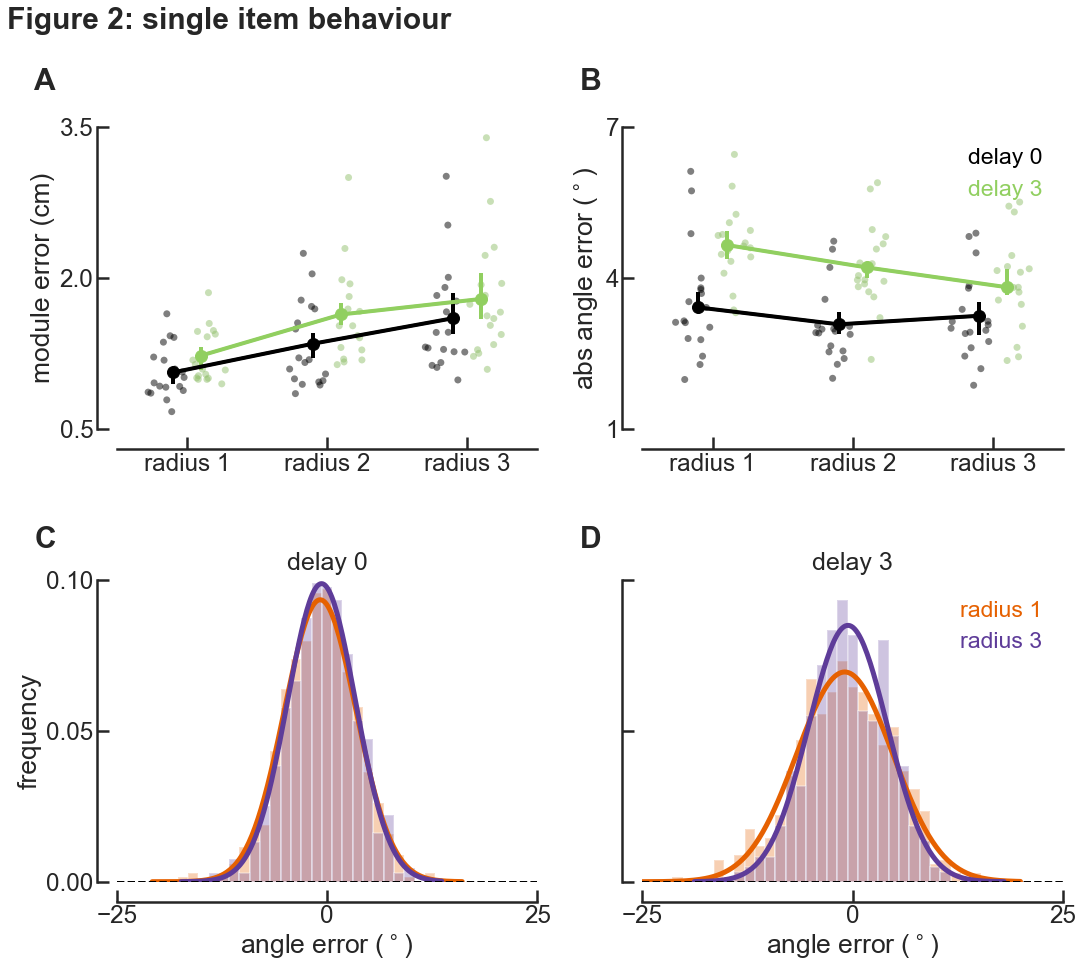

In [43]:
### Figure paper

boots=10 #000

f = plt.figure(figsize=(15,12))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)


f.text(0, 1.1, "Figure 2: single item behaviour ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.025, 1.03, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.53, 1.03, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.025, 0.5, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.53, 0.5, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


plt.subplot(221)

linares_plot(x='r_T', y='modules', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.5, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=boots)
plt.legend(frameon=False)
#plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'module error (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(0.5, 3.5)

l = plt.legend(loc=1, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('')
l.get_texts()[1].set_text('')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'], rotation=0)
plt.yticks([0.5,2,3.5])




plt.subplot(222)

linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.5, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=boots, leg=False)

#plt.legend(frameon=False)
#plt.title('error in eccentricity', fontsize=25, pad=10)
plt.xlabel('')

plt.ylabel(r'abs angle error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')

adjust_spines(plt.gca(), ['left', 'bottom'])

#plt.ylim(2, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'], rotation=0)
plt.yticks([1,4,7])


plt.subplot(223)

# read data from a text file. One number per line
datos_d0_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==0)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d0_r1)
datos_d0_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==0)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d0_r3)

sns.distplot(datos_d0_r1, color= c_r1, fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax3, hist_kws={'alpha':0.3})
sns.distplot(datos_d0_r3, color=c_r3, fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax3, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('frequency')
#plt.title(r'$\mathrm{Delay=0:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('delay 0',  fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
adjust_spines(plt.gca(), ['left', 'bottom'])



plt.yticks([0, 0.05,0.1])
plt.xticks([-25, 0, 25])
plt.legend(frameon=False)
plt.ylim(0,0.1)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.xlim(-25,25)


plt.subplot(224)

# read data from a text file. One number per line
datos_d3_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==3)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d3_r1)
datos_d3_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==3)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d3_r3)

sns.distplot(datos_d3_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax4, hist_kws={'alpha':0.3})
sns.distplot(datos_d3_r3, color=c_r3, fit=norm, kde=False, label='radius 3', fit_kws={"color":c_r3, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax4, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('delay 3', fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0,0.05,0.1], ['', ''])
plt.xticks([-25, 0, 25])


plt.ylim(0,0.1)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.xlim(-25,25)

adjust_spines(plt.gca(), ['left', 'bottom'])


l = plt.legend(loc=1, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.5)

plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-p

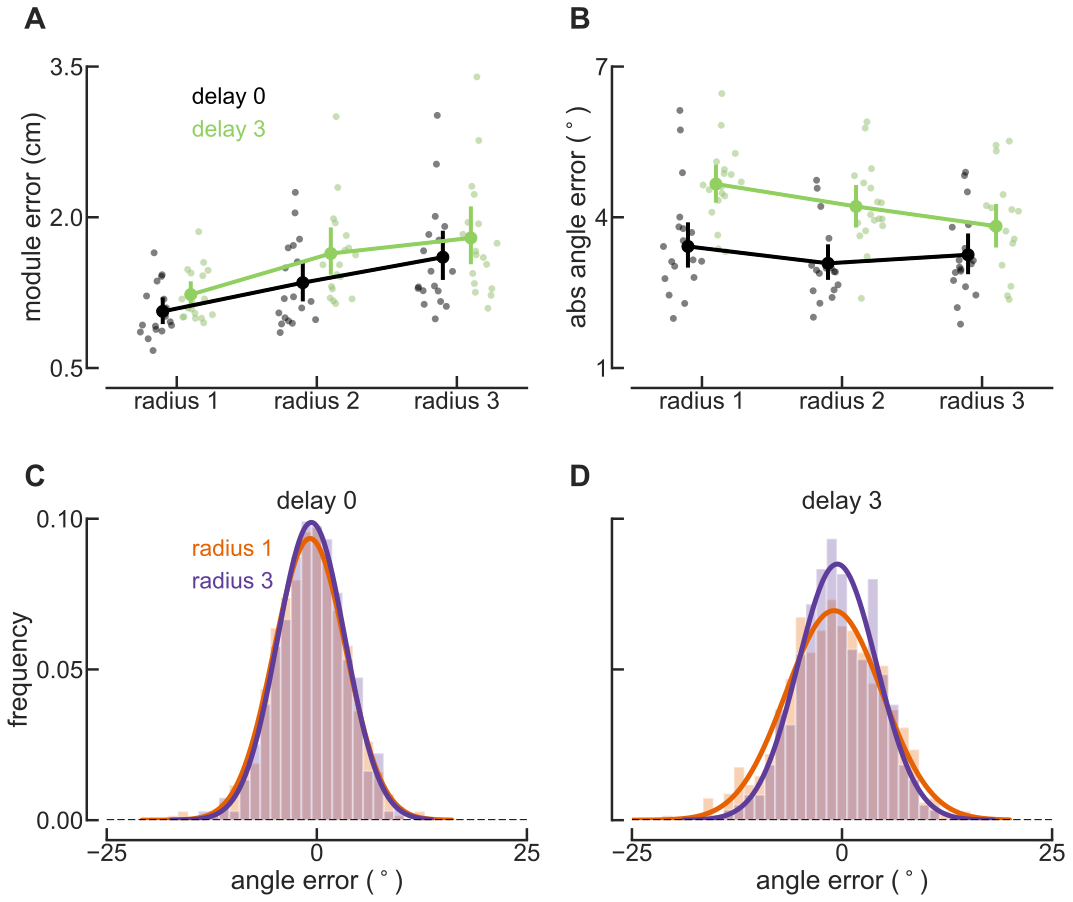

In [55]:
### Figure paper
%config InlineBackend.figure_format = 'svg'

boots=10000

f = plt.figure(figsize=(15,12))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)


#f.text(0, 1.1, "Figure 2: single item behaviour ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.025, 1.03, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.53, 1.03, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.025, 0.5, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.53, 0.5, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


plt.subplot(221)

linares_plot(x='r_T', y='modules', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.5, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=boots, leg=False)

#plt.legend(frameon=False)
#plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'module error (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(0.5, 3.5)

l = plt.legend(loc='best', frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'], rotation=0)
plt.yticks([0.5,2,3.5])




plt.subplot(222)

linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.5, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=boots, leg=False)

#plt.legend(frameon=False)
#plt.title('error in eccentricity', fontsize=25, pad=10)
plt.xlabel('')

plt.ylabel(r'abs angle error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')

adjust_spines(plt.gca(), ['left', 'bottom'])

#plt.ylim(2, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('')
l.get_texts()[1].set_text('')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'], rotation=0)
plt.yticks([1,4,7])


plt.subplot(223)

# read data from a text file. One number per line
datos_d0_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==0)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d0_r1)
datos_d0_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==0)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d0_r3)

sns.distplot(datos_d0_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax3, hist_kws={'alpha':0.3})
sns.distplot(datos_d0_r3, color=c_r3, fit=norm, kde=False, label='radius 3',fit_kws={"color":c_r3, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax3, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('frequency')
#plt.title(r'$\mathrm{Delay=0:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('delay 0',  fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
adjust_spines(plt.gca(), ['left', 'bottom'])



plt.yticks([0, 0.05,0.1])
plt.xticks([-25, 0, 25])
plt.legend(frameon=False)
plt.ylim(0,0.1)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.xlim(-25,25)


l = plt.legend(loc=2, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


plt.subplot(224)

# read data from a text file. One number per line
datos_d3_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==3)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d3_r1)
datos_d3_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==3)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d3_r3)

sns.distplot(datos_d3_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax4, hist_kws={'alpha':0.3})
sns.distplot(datos_d3_r3, color=c_r3, fit=norm, kde=False, label='radius 3', fit_kws={"color":c_r3, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax4, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('delay 3', fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0,0.05,0.1], ['', ''])
plt.xticks([-25, 0, 25])


plt.ylim(0,0.1)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.xlim(-25,25)

adjust_spines(plt.gca(), ['left', 'bottom'])


# l = plt.legend(loc=1, frameon=False, prop={'size': 23})
# l.get_texts()[0].set_text('radius 1');
# l.get_texts()[0].set_color(c_r1);
# l.get_texts()[1].set_text('radius 3');
# l.get_texts()[1].set_color(c_r3);
# l.legendHandles[0].set_visible(False);
# l.legendHandles[1].set_visible(False);


plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.5)

plt.show()

In [56]:
boots=10

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mean

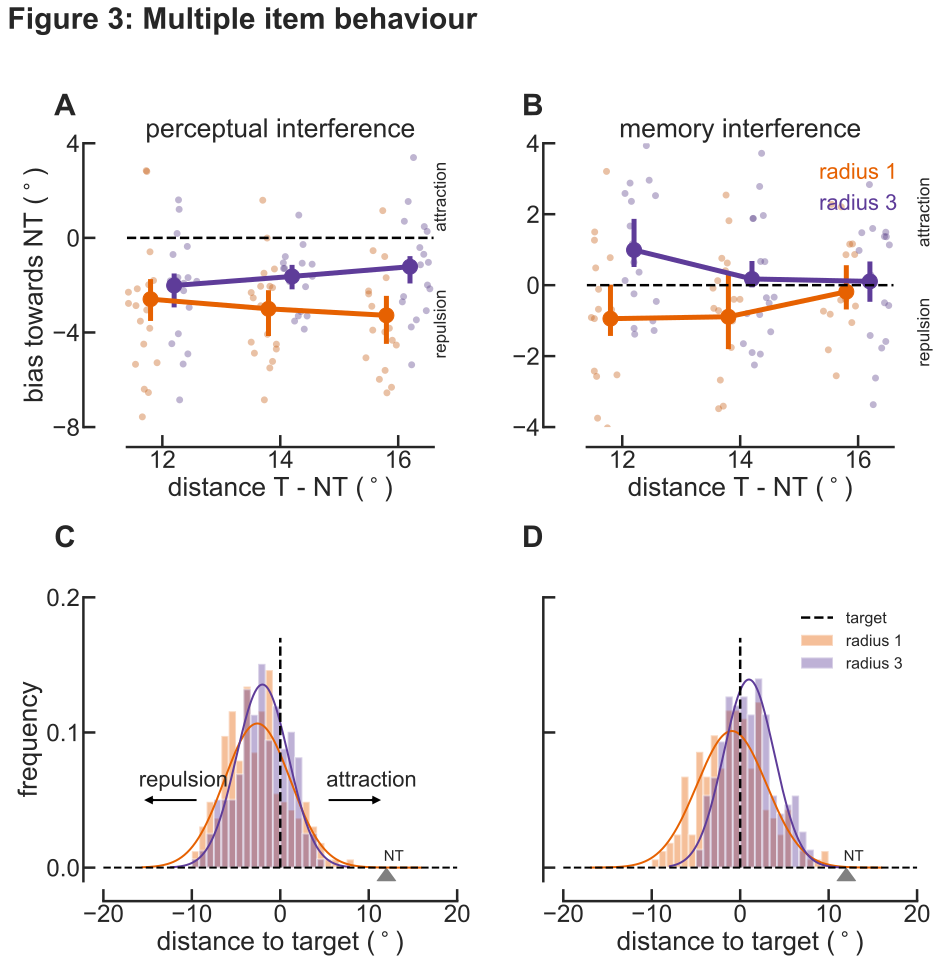

In [57]:
f = plt.figure(figsize=(13,12))
ax = f.add_subplot(223)
ax2 = f.add_subplot(224)


f.text(0, 1.1, "Figure 3: Multiple item behaviour ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.05, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.55, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.05, 0.5, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.55, 0.5, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)




plt.subplot(221)


linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject',
            plot_box='line',  LW=5, MS=15, reps=boots)


plt.legend(frameon=False)
plt.title('perceptual interference')
plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.xticks([0,1,2], ['12', '16', '20'])
plt.ylabel(r'bias towards NT ($^\circ$)');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(-8,4)
plt.yticks([-8,-4,0,4])
plt.text(2.3, 2.7, 'attraction', fontsize=17, rotation='vertical');
plt.text(2.3, -2.7, 'repulsion', fontsize=17, rotation='vertical');
l = plt.legend(loc=2, frameon=False, prop={'size': 20})
l.get_texts()[0].set_text('')
l.get_texts()[1].set_text('')
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


plt.subplot(222)

linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=7,  
             by_subj=True, subj_col='subject',
              plot_box='line', LW=5, MS=15, reps=boots)
plt.legend(frameon=False)
plt.title('memory interference')
plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.xticks([0,1,2], ['12', '16', '20'])
plt.ylabel('');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(-4,4)
plt.yticks([-4,-2,0,2,4])
plt.text(2.5, 2.7, 'attraction', fontsize=17, rotation='vertical');
plt.text(2.5, -0.7, 'repulsion', fontsize=17, rotation='vertical');
l = plt.legend(loc=1, frameon=False, prop={'size': 22})
l.get_texts()[0].set_text('radius 1')
l.get_texts()[1].set_text('radius 3')
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);




plt.subplot(223)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'distance_A_err'] , bins=np.linspace(-10,10,25), 
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'distance_A_err'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3,ax=ax)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-20,20)
plt.plot([-20,20], [0,0], 'k--', linewidth=2);
plt.xticks([-20, -10, 0, 10, 20])
plt.ylim(-0.01, 0.02)
plt.yticks([0, 0.1,0.2])
#plt.plot([12, 12], [0,0.17], color='grey', linestyle='-', linewidth=2.5, label='NT');
#plt.plot((12,10), "^", color='grey', markersize=10, label='NT=12');

#l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.text(5.2, 0.06, 'attraction', fontsize=22);
plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay0')
#plt.title('perceptual distribution')
plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');

plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');


#pts = [(11, 0), (12, 0.01), (13, 0)]
pts = [(11, -0.010), (12, -0.001), (13, -0.010)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax.add_patch(triangle)
plt.text(11.7, 0.005, 'NT', fontsize=15);

adjust_spines(plt.gca(), ['left', 'bottom'])


plt.subplot(224)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax2)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3, ax=ax2)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-20,20)
plt.xticks([-20, -10, 0, 10, 20])
plt.ylim(-0.01, 0.02)
plt.plot([-20,20], [0,0], 'k--', linewidth=2);

##triangulo locura
#plt.plot((12,10), "^", color='grey', markersize=10, label='NT=12');



l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('')
#plt.text(5.2, 0.06, 'attraction', fontsize=22);
#plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0,0.1,0.2], ['', '',  ''])

#plt.title('memory distribution')
# plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='left', verticalalignment='bottom');

# plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
#            horizontalalignment='left', verticalalignment='bottom');




pts = [(11, -0.010), (12, -0.001), (13, -0.010)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)
plt.text(11.7, 0.005, 'NT', fontsize=15);



adjust_spines(plt.gca(), ['left', 'bottom'])

plt.tight_layout()


plt.subplots_adjust(wspace=0.3, hspace=0.6)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  wa

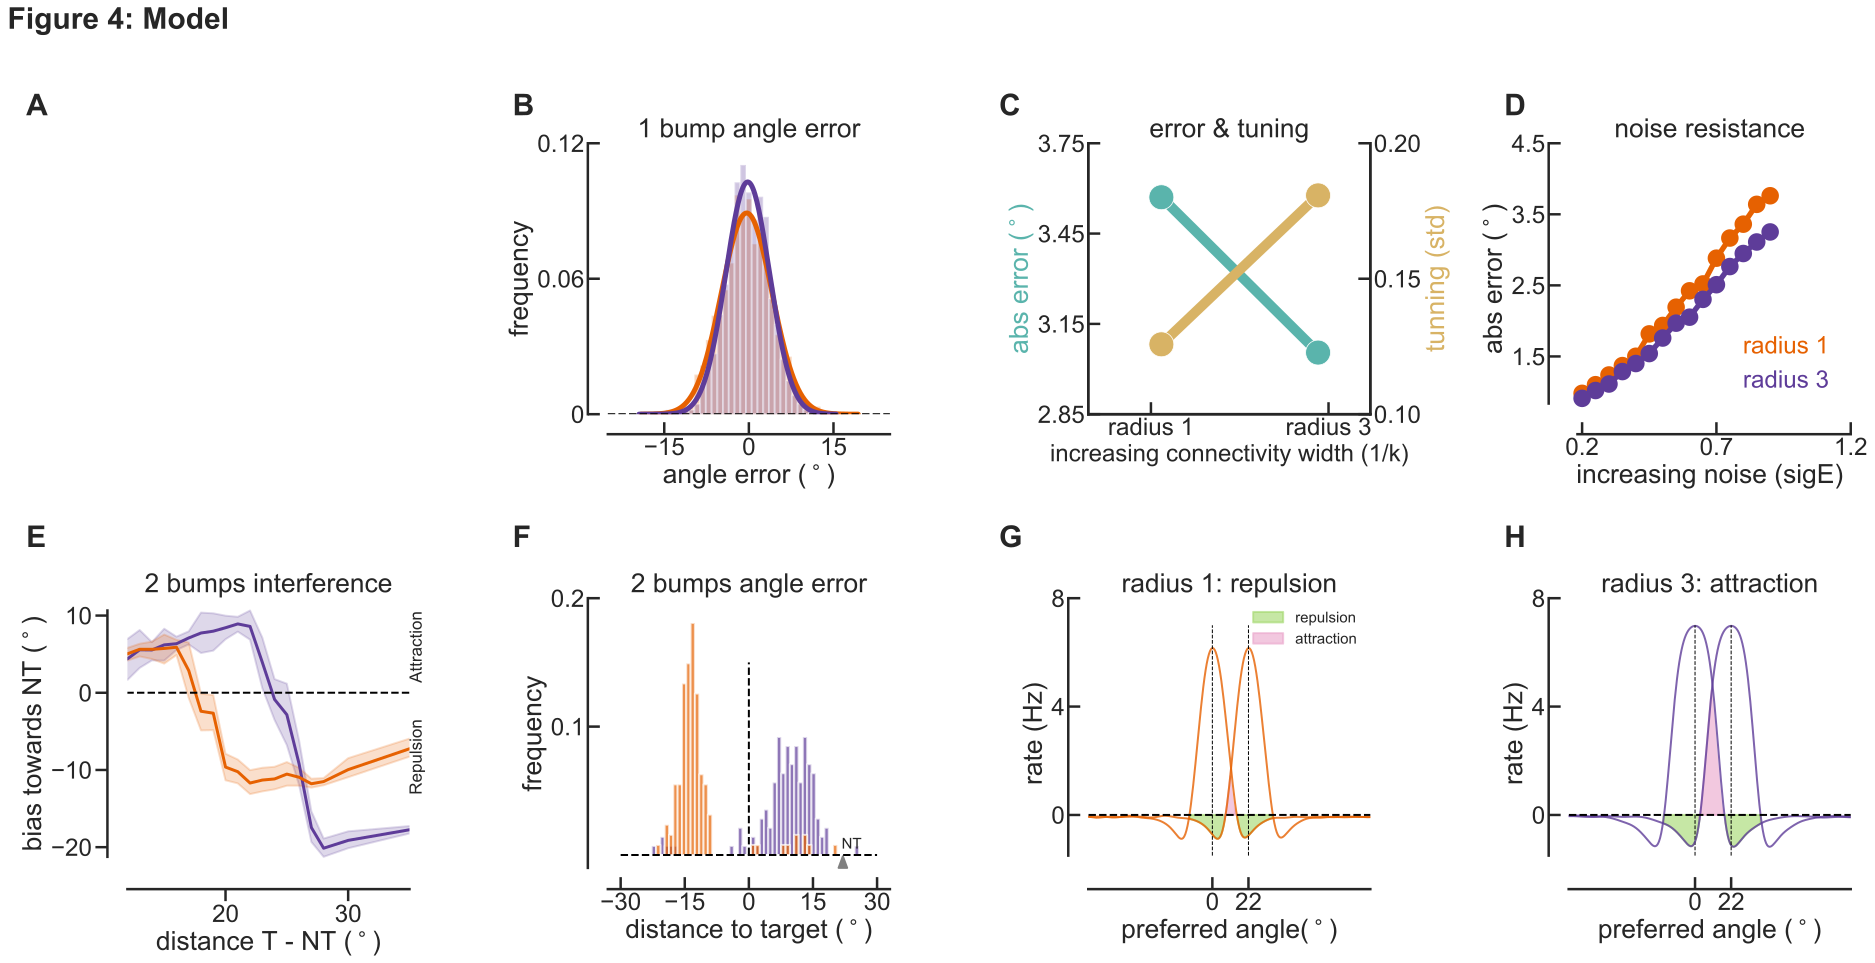

In [58]:
f = plt.figure(figsize=(26,12))
axinv=  f.add_subplot(241)
ax1 = f.add_subplot(242)
ax2 = f.add_subplot(243)
ax3 = f.add_subplot(244)
ax4 = f.add_subplot(245)
ax5 = f.add_subplot(246)

f.text(0, 1.1, "Figure 4: Model ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.01, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


### 2nd plot
f.text(0.53, 1.0, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


c_tuning= '#d8b365' #'#e9a3c9'
c_error = '#5ab4ac' #'#a1d76a'
sns.lineplot( x="kappas_E", y="abs_bias", ci=None, data=df_1, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_error, ax=ax2) 
ax2.set_ylim(2.85, 3.75)
ax2.set_yticks([2.85, 3.15, 3.45, 3.75])
ax2.set_ylabel(r'abs error ($^\circ$)')
ax2.spines['top'].set_visible(False)
ax2.tick_params(direction='in')
plt.xlabel('')
ax2.set_xlim(200, 335)
ax2.set_xticks([305, 220])
ax2.set_xticklabels(['radius 1','radius 3'])
ax2.invert_xaxis()
ax2.set_xlabel('increasing connectivity width (1/k)', fontsize=24)
ax2.yaxis.label.set_color(c_error)
ax12 = ax2.twinx()
sns.lineplot( x="kappas_E", y="gaussian_std", ci=None, data=df_fg, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_tuning, ax=ax12) 

ax12.set_ylim(0.1, 0.2)
ax12.spines['top'].set_visible(False)
ax12.set_yticks([0.1, 0.15, 0.2])
ax12.set_ylabel('tunning (std)')
ax12.tick_params(direction='in')
ax12.set_xlabel('increasing connectivity width (1/k)', fontsize=24)
ax12.set_xticks([305, 220])
ax12.set_xticklabels(['radius 1','radius 3'])
ax12.yaxis.label.set_color(c_tuning)
plt.title('error & tuning')


#### 1st plot
f.text(0.27, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(242)
sns.distplot(df_1.loc[df_1['kappas_E']==300, 'b2'], color=c_r1,  bins=np.linspace(-30,30,60),
             label='radius 1', kde=False, fit=norm,  fit_kws={"color":c_r1, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax1)

sns.distplot(df_1.loc[df_1['kappas_E']==225, 'b2'], color=c_r3,  bins=np.linspace(-30,30,60),
             label='radius 3', kde=False, fit=norm,  fit_kws={"color":c_r3, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax1)

plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
plt.title('1 bump angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0, 0.06,  0.12], [0, 0.06, 0.12])
plt.xticks([-15, 0, 15])
plt.ylim(0,0.12)
plt.xlim(-25,25)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.ylabel('frequency')
# l = plt.legend(loc=1, frameon=False, prop={'size': 18})
# l.get_texts()[0].set_text('radius 1: k=300');
# l.get_texts()[0].set_color(c_r1);
# l.get_texts()[1].set_text('radius 3: k=225');
# l.get_texts()[1].set_color(c_r3);
# l.legendHandles[0].set_visible(False);
# l.legendHandles[1].set_visible(False);
adjust_spines(plt.gca(), ['left', 'bottom'])




### 3th plot
f.text(0.8, 1.0, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


c_tuning= '#e9a3c9'
g =sns.factorplot( x="sigE", y="absb2", hue='kappa_E', data=df___, palette=[c_r1, c_r3], hue_order=[300,225],
                  ci=None, size=5, aspect=1.5, legend=False, ax=ax3);
plt.setp(g.ax.lines, linewidth=7)
plt.close()
ax3.set_ylabel(r'abs error ($^\circ$)')
ax3.set_xlabel('increasing noise (sigE)')
ax3.set_title('noise resistance')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()
ax3.tick_params(direction='in')
ax3.set_xlim(-1, 20)
ax3.set_xticks([0,10,20])
ax3.set_xticklabels( [0.2, 0.7, 1.2])
l=ax3.legend(frameon=False, loc=4)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
adjust_spines(ax3, ['left', 'bottom'])
ax3.set_yticks([ 1.5, 2.5, 3.5, 4.5]);




##4th plot
f.text(0.01, 0.5, "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model, legend=False, ax=ax4) 
ax4.plot([0, max(df_model['separation'])], [0,0], 'k--', linewidth=2) 
#plt.title('model: memory bias', fontsize=25) #condition title
ax4.spines['right'].set_visible(False) #no right axis
ax4.spines['top'].set_visible(False) #no  top axis
ax4.get_xaxis().tick_bottom()
ax4.get_yaxis().tick_left()
# l = ax4.legend(loc=3, frameon=False, prop={'size': 16})
# l.get_texts()[0].set_text('');
# l.get_texts()[1].set_text('radius 1: k=300');
# l.get_texts()[1].set_color(c_r1);
# l.get_texts()[2].set_text('radius 3: k=225');
# l.get_texts()[2].set_color(c_r3);
# l.legendHandles[1].set_visible(False);
# l.legendHandles[2].set_visible(False);
ax4.set_xlim(12, 35)
ax4.text(35, 9, 'Attraction', fontsize=17, rotation='vertical');
ax4.text(35, -5, 'Repulsion', fontsize=17, rotation='vertical');
ax4.set_xlabel(r'distance T - NT ($^\circ$)');
ax4.set_ylabel(r'bias towards NT ($^\circ$)');
adjust_spines(ax4, ['left', 'bottom'])
ax4.set_title('2 bumps interference')





### 5th plot
f.text(0.27, 0.5, "F", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(246)
sns.distplot(values_225, color=c_r3, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
              label='radius 3', hist_kws={"alpha":0.7}, fit_kws={"color":c_r3, 'linewidth':0}, ax=ax5)
sns.distplot(values_300,  color=c_r1, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
             label='radius 1', hist_kws={"alpha":0.7}, fit_kws={"color":c_r1, 'linewidth':0}, ax=ax5)


ax5.plot([-30, 30], [0,0], 'k--', linewidth=2) 
ax5.plot([0,0], [0,0.15], 'k--', linewidth=2, label='target') 
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.yticks([0.1,0.2, 0.3])
plt.xticks([-30, -15, 0, 15, 30])
plt.xlim(-33, 33)
plt.ylim(-0.011,0.2)
# l = plt.legend(loc=1, frameon=False, prop={'size': 16})
# l.get_texts()[0].set_text('target');
# l.get_texts()[1].set_text('radius 1: k=300');
# l.get_texts()[1].set_color(c_r1);
# l.get_texts()[2].set_text('radius 3: k=225');
# l.get_texts()[2].set_color(c_r3);
# l.legendHandles[1].set_color(c_r1);
# l.legendHandles[2].set_color(c_r3);
adjust_spines(plt.gca(), ['left', 'bottom'])
pts = [(21, -0.01), (22, -0.001), (23, -0.01)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax5.add_patch(triangle)
plt.text(21.7, 0.005, 'NT', fontsize=15);
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('2 bumps angle error')



### 6th plot
f.text(0.53, 0.5, "G", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(247)
static = current_300
displaced= np.roll(current_300, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r1, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r1, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 1: repulsion')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[13:16]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


### 7th plot
f.text(0.8, 0.5, "H", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(248)
static = current_225
displaced= np.roll(current_225, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r3, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r3, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 3: attraction')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[5:8]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle ($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])

f.delaxes(axinv)

plt.tight_layout(h_pad=8, w_pad=3)

plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  wa

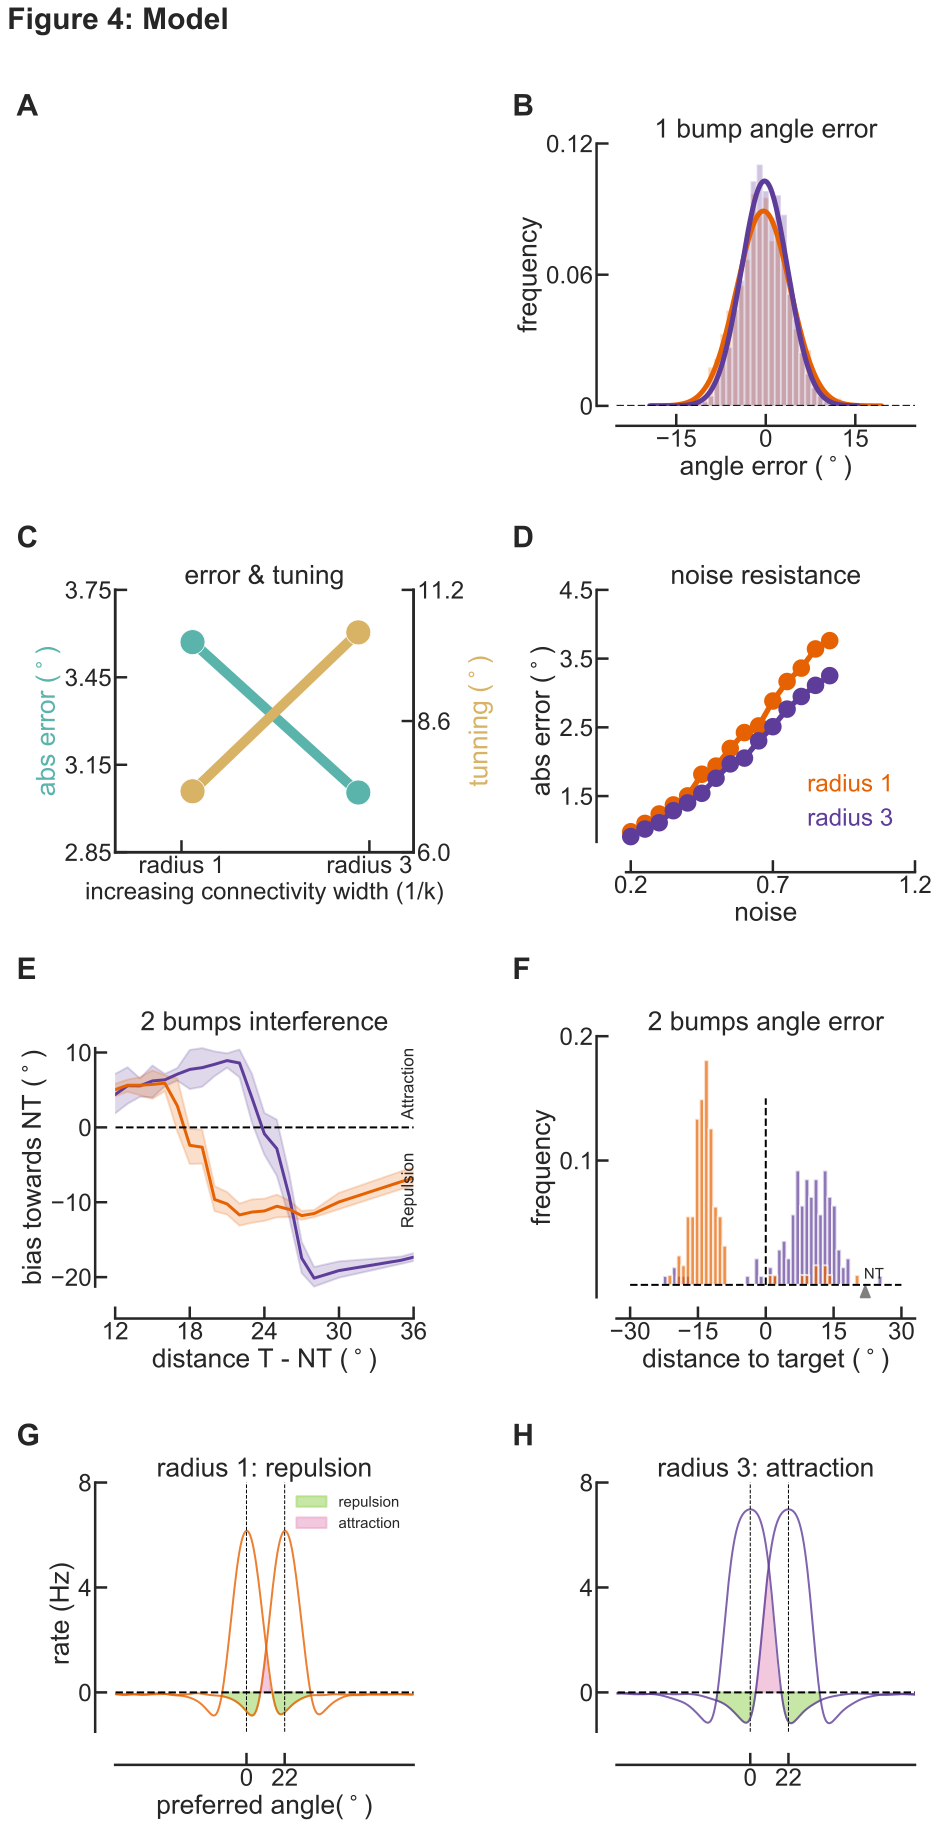

In [61]:
f = plt.figure(figsize=(13,24))
axinv=  f.add_subplot(421)
ax1 = f.add_subplot(422)
ax2 = f.add_subplot(423)
ax3 = f.add_subplot(424)
ax4 = f.add_subplot(425)
ax5 = f.add_subplot(426)

f.text(0, 1.05, "Figure 4: Model ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.01, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.54, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.01, 0.75, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.54, 0.75, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.01, 0.50, "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.54, 0.50, "F", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.01, 0.23, "G", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.54, 0.23, "H", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


### 2nd plot



c_tuning= '#d8b365' #'#e9a3c9'
c_error = '#5ab4ac' #'#a1d76a'
sns.lineplot( x="kappas_E", y="abs_bias", ci=None, data=df_1, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_error, ax=ax2) 
ax2.set_ylim(2.85, 3.75)
ax2.set_yticks([2.85, 3.15, 3.45, 3.75])
ax2.set_ylabel(r'abs error ($^\circ$)')
ax2.spines['top'].set_visible(False)
ax2.tick_params(direction='in')
plt.xlabel('')
ax2.set_xlim(200, 335)
ax2.set_xticks([305, 220])
ax2.set_xticklabels(['radius 1','radius 3'])
ax2.invert_xaxis()
ax2.set_xlabel('increasing connectivity width (1/k)', fontsize=24)
ax2.yaxis.label.set_color(c_error)
ax12 = ax2.twinx()
sns.lineplot( x="kappas_E", y="gaussian_std_deg", ci=None, data=df_fg, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_tuning, ax=ax12) 

ax12.set_ylim(6,11.2)
ax12.spines['top'].set_visible(False)
ax12.set_yticks([6,8.6,11.2])
ax12.set_ylabel(r'tunning ($^\circ$)')
ax12.tick_params(direction='in')
ax12.set_xlabel('increasing connectivity width (1/k)', fontsize=24)
ax12.set_xticks([305, 220])
ax12.set_xticklabels(['radius 1','radius 3'])
ax12.yaxis.label.set_color(c_tuning)
plt.title('error & tuning')


#### 1st plot

plt.subplot(422)
sns.distplot(df_1.loc[df_1['kappas_E']==300, 'b2'], color=c_r1,  bins=np.linspace(-30,30,60),
             label='radius 1', kde=False, fit=norm,  fit_kws={"color":c_r1, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax1)

sns.distplot(df_1.loc[df_1['kappas_E']==225, 'b2'], color=c_r3,  bins=np.linspace(-30,30,60),
             label='radius 3', kde=False, fit=norm,  fit_kws={"color":c_r3, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax1)

plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
plt.title('1 bump angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0, 0.06,  0.12], [0, 0.06, 0.12])
plt.xticks([-15, 0, 15])
plt.ylim(0,0.12)
plt.xlim(-25,25)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.ylabel('frequency')
# l = plt.legend(loc=1, frameon=False, prop={'size': 18})
# l.get_texts()[0].set_text('radius 1: k=300');
# l.get_texts()[0].set_color(c_r1);
# l.get_texts()[1].set_text('radius 3: k=225');
# l.get_texts()[1].set_color(c_r3);
# l.legendHandles[0].set_visible(False);
# l.legendHandles[1].set_visible(False);
adjust_spines(plt.gca(), ['left', 'bottom'])




### 3th plot


c_tuning= '#e9a3c9'
g =sns.factorplot( x="sigE", y="absb2", hue='kappa_E', data=df___, palette=[c_r1, c_r3], hue_order=[300,225],
                  ci=None, size=5, aspect=1.5, legend=False, ax=ax3);
plt.setp(g.ax.lines, linewidth=7)
plt.close()
ax3.set_ylabel(r'abs error ($^\circ$)')
ax3.set_xlabel('noise')
ax3.set_title('noise resistance')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()
ax3.tick_params(direction='in')
ax3.set_xlim(-1, 20)
ax3.set_xticks([0,10,20])
ax3.set_xticklabels( [0.2, 0.7, 1.2])
l=ax3.legend(frameon=False, loc=4)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
adjust_spines(ax3, ['left', 'bottom'])
ax3.set_yticks([ 1.5, 2.5, 3.5, 4.5]);




##4th plot


g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model, legend=False, ax=ax4) 
ax4.plot([0, max(df_model['separation'])], [0,0], 'k--', linewidth=2) 
#plt.title('model: memory bias', fontsize=25) #condition title
ax4.spines['right'].set_visible(False) #no right axis
ax4.spines['top'].set_visible(False) #no  top axis
ax4.get_xaxis().tick_bottom()
ax4.get_yaxis().tick_left()
# l = ax4.legend(loc=3, frameon=False, prop={'size': 16})
# l.get_texts()[0].set_text('');
# l.get_texts()[1].set_text('radius 1: k=300');
# l.get_texts()[1].set_color(c_r1);
# l.get_texts()[2].set_text('radius 3: k=225');
# l.get_texts()[2].set_color(c_r3);
# l.legendHandles[1].set_visible(False);
# l.legendHandles[2].set_visible(False);
ax4.tick_params(direction='in')
ax4.set_xticks([12,18, 24, 30, 36])
ax4.set_xlim(12, 36)
ax4.text(35, 9, 'Attraction', fontsize=17, rotation='vertical');
ax4.text(35, -5, 'Repulsion', fontsize=17, rotation='vertical');
ax4.set_xlabel(r'distance T - NT ($^\circ$)');
ax4.set_ylabel(r'bias towards NT ($^\circ$)');
adjust_spines(ax4, ['left', 'bottom'])
ax4.set_title('2 bumps interference')





### 5th plot

plt.subplot(426)
sns.distplot(values_225, color=c_r3, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
              label='radius 3', hist_kws={"alpha":0.7}, fit_kws={"color":c_r3, 'linewidth':0}, ax=ax5)
sns.distplot(values_300,  color=c_r1, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
             label='radius 1', hist_kws={"alpha":0.7}, fit_kws={"color":c_r1, 'linewidth':0}, ax=ax5)


ax5.plot([-30, 30], [0,0], 'k--', linewidth=2) 
ax5.plot([0,0], [0,0.15], 'k--', linewidth=2, label='target') 
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.yticks([0.1,0.2, 0.3])
plt.xticks([-30, -15, 0, 15, 30])
plt.xlim(-33, 33)
plt.ylim(-0.011,0.2)
# l = plt.legend(loc=1, frameon=False, prop={'size': 16})
# l.get_texts()[0].set_text('target');
# l.get_texts()[1].set_text('radius 1: k=300');
# l.get_texts()[1].set_color(c_r1);
# l.get_texts()[2].set_text('radius 3: k=225');
# l.get_texts()[2].set_color(c_r3);
# l.legendHandles[1].set_color(c_r1);
# l.legendHandles[2].set_color(c_r3);
adjust_spines(plt.gca(), ['left', 'bottom'])
pts = [(21, -0.01), (22, -0.001), (23, -0.01)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax5.add_patch(triangle)
plt.text(21.7, 0.005, 'NT', fontsize=15);
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('2 bumps angle error')



### 6th plot

plt.subplot(427)
static = current_300
displaced= np.roll(current_300, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r1, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,8], 'k--', linewidth=1)
plt.plot(displaced, color=c_r1, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,8], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 1: repulsion')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[13:16]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


### 7th plot

plt.subplot(428)
static = current_225
displaced= np.roll(current_225, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r3, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,8], 'k--', linewidth=1)
plt.plot(displaced, color=c_r3, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,8], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 3: attraction')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[5:8]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'')
plt.ylabel(r'')
adjust_spines(plt.gca(), ['left', 'bottom'])

f.delaxes(axinv)
plt.tight_layout(h_pad=8, w_pad=3)

plt.show()

In [63]:
df_m.head()
df_m.radius.unique()
df_m['radius_cm'] = df_m['radius'].copy()
df_m['radius_cm'].replace([1,2,3], [])


array([1, 2, 3], dtype=int64)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  

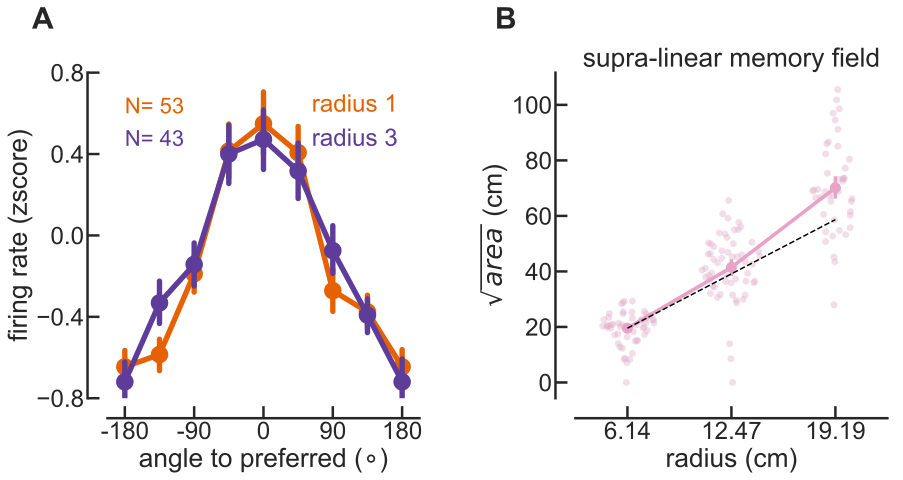

In [59]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#f.text(0.05, 1.15, "Figure 5: electrophysiology ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.05, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.51, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(121);

sns.factorplot( x="angle", y="firing", data=df_firings, hue='radius', 
               palette=[c_r1, c_r3], ci=68, size=6, aspect=1.5, legend=False, ax=ax);
plt.close()
ax.set_xlabel(r'angle to preferred ($\circ$)');
ax.set_ylabel('firing rate (zscore)')
#ax.set_title('tuning curves')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(direction='in')
ax.set_xticks([ 0, 2, 4, 6, 8])

n_r1 = len(df_firings.loc[(df_firings['radius']==' radius 1') & (df_firings['angle']==0) ])
n_r3 = len(df_firings.loc[(df_firings['radius']=='radius 2') & (df_firings['angle']==0) ])
plt.text(0, 0.6, 'N= ' + str(n_r1), fontsize=22, color=c_r1);
plt.text(0, 0.44, 'N= ' + str(n_r3), fontsize=22, color=c_r3);

ax.set_xticklabels([-180, -90, 0, 90, 180]);

l= ax.legend(loc=1, frameon=False)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

ax.set_ylim(-0.8, 0.8);
ax.set_yticks([ -0.8, -0.4, 0, 0.4, 0.8]);
adjust_spines(ax, ['left', 'bottom'])



# plt.subplot(122); ### previous one, increase of circular std
# # g = sns.factorplot( x="radius", y="tuning_std", data=df_m, palette=c_tuning, ci=68, size=5, aspect=1.5, ax=ax2);
# df_m['tuning_std_deg'] = df_m['tuning_std']*180/np.pi

# linares_plot(x='radius', y='tuning_std_deg', order=[1,2,3], 
#              alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=5, MS=15, reps=1000)
# #plt.close()
# ax2.set_xlabel(r'')
# ax2.set_ylabel(r'tuning curve width ($\circ$)')
# #ax2.set_title('tuning curve width ($\circ$)')
# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.get_xaxis().tick_bottom()
# ax2.get_yaxis().tick_left()
# ax2.tick_params(direction='in')
# ax2.set_ylim( 60,180)
# ax2.set_yticks([60,120, 180]);
# ax2.set_xlim(-0.4, 2.4);
# ax2.set_xticks([0,1,2])
# ax2.set_xticklabels(['radius 1', 'radius 2', 'radius 3'])
# adjust_spines(ax2, ['left', 'bottom'])



# plt.subplots_adjust(wspace=0.4)




plt.subplot(122)


linares_plot(x='rad_cm', y='area_', order=[r1cm, r2cm, r3cm], CI=0.95,
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=3.5, MS=10, reps=100)

plt.ylabel(r'$\sqrt{area}$ (cm)')
plt.xlabel(r'radius (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.title('supra-linear memory field')
#plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.legend(frameon=False)
#plt.ylim(1.65, 2.2);
#plt.yticks([ 1.8, 2, 2.2]);
#plt.gca().set_ylim( 60,180)
#plt.gca().set_yticks([60,120, 180]);

plt.gca().plot([0,1,2], 
               [df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean(), 
                df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean()*2, 
                df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean()*3   ], 'k--', linewidth=1.5, zorder=3) #zorder defines the order in the plot

#plt.ylim(0,100)
plt.subplots_adjust(wspace=0.5)





In [67]:
df_m.rad_cm.unique()

array([ 6.14, 12.47, 19.19])

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


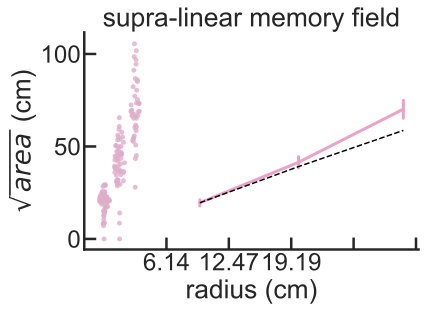

In [77]:
# linares_plot(x='rad_cm', y='area_', order=[r1cm, r2cm, r3cm], CI=0.95,
#              alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=3.5, MS=10, reps=100)



sinaplot.sinaplot(x="rad_cm", y="area_", data=df_m, violin=False, point_size=5, palette=[c_tuning],
                      alpha=0.8, order=df_m.rad_cm.unique())

sns.lineplot(x="rad_cm", y="area_", err_style="bars", ci=95, color=c_tuning, data=df_m)

plt.ylabel(r'$\sqrt{area}$ (cm)')
plt.xlabel(r'radius (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.title('supra-linear memory field')

#plt.xticks(df_m.rad_cm.unique(), ['radius 1', 'radius 2', 'radius 3'])
plt.xticks([4,8,12,16,20,24])
plt.legend(frameon=False)
#plt.ylim(1.65, 2.2);
#plt.yticks([ 1.8, 2, 2.2]);
#plt.gca().set_ylim( 60,180)
#plt.gca().set_yticks([60,120, 180]);

plt.gca().plot(df_m.rad_cm.unique(), 
               [df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean(), 
                df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean()*2, 
                df_m.loc[df_m['rad_cm']==r1cm, 'area_'].mean()*3   ], 'k--', linewidth=1.5, zorder=3) #zorder defines the order in the plot


In [99]:
import matplotlib.pyplot as plt
from seaborn.categorical import _ViolinPlotter
import numpy as np


class _SinaPlotter2(_ViolinPlotter):

    def __init__(self, x, y, hue, data, order, hue_order,
                 bw, cut, scale, scale_hue, gridsize,
                 width, inner, split, dodge, orient, linewidth,
                 color, palette, saturation,
                 violin_facealpha, point_facealpha):
        # initialise violinplot
        super(_SinaPlotter2, self).__init__(
            x, y, hue, data, order, hue_order,
            bw, cut, scale, scale_hue, gridsize,
            width, inner, split, dodge, orient, linewidth,
            color, palette, saturation
        )

        # Set object attributes
        self.dodge = dodge
        # bit of a hack to set color alphas for points and violins
        self.point_colors = [(*color, point_facealpha) for color in self.colors]
        self.colors = [(*color, violin_facealpha) for color in self.colors]

    def jitterer(self, values, support, density):
        if values.size:
            max_density = np.interp(values, support, density)
            max_density *= self.dwidth
            low = 0 if self.split else -1
            jitter = np.random.uniform(low, 1, size=len(max_density)) * max_density
        else:
            jitter = np.array([])
        return jitter

    def draw_sinaplot(self, ax, kws):
        """Draw the points onto `ax`."""
        # Set the default zorder to 2.1, so that the points
        # will be drawn on top of line elements (like in a boxplot)
        counter=0
        x_vaal=[]
        y_vaal=[]
        for i, group_data in enumerate(self.plot_data):
            xs_c=df_m.rad_cm.unique()          
            if self.plot_hues is None or not self.dodge:

                if self.hue_names is None:
                    hue_mask = np.ones(group_data.size, np.bool)
                else:
                    hue_mask = np.array([h in self.hue_names
                                         for h in self.plot_hues[i]], np.bool)
                    # Broken on older numpys
                    # hue_mask = np.in1d(self.plot_hues[i], self.hue_names)

                strip_data = group_data[hue_mask]
                density = self.density[i]
                support = self.support[i]

                # Plot the points in centered positions
                cat_pos = np.ones(strip_data.size) * i
                cat_pos += self.jitterer(strip_data, support, density)
                kws.update(color=self.point_colors[i])
                if self.orient == "v":
                    cat_pos=cat_pos+xs_c[counter]
                    ax.scatter(cat_pos, strip_data, **kws)
                    x_vaal.append(cat_pos)
                    y_vaal.append(strip_data)
                    counter+=1
                else:
                    ax.scatter(strip_data, cat_pos, **kws)
                    data_xx = cat_pos

            else:
                offsets = self.hue_offsets
                for j, hue_level in enumerate(self.hue_names):
                    hue_mask = self.plot_hues[i] == hue_level
                    strip_data = group_data[hue_mask]
                    density = self.density[i][j]
                    support = self.support[i][j]
                    if self.split:
                        # Plot the points in centered positions
                        center = i
                        cat_pos = np.ones(strip_data.size) * center
                        jitter = self.jitterer(strip_data, support, density)
                        cat_pos = cat_pos + jitter if j else cat_pos - jitter
                        kws.update(color=self.point_colors[j])
                        if self.orient == "v":
                            ax.scatter(cat_pos, strip_data, zorder=2, **kws)
                            data_xx = cat_pos
                        else:
                            ax.scatter(strip_data, cat_pos, zorder=2, **kws)
                            data_xx = cat_pos
                    else:
                        # Plot the points in centered positions
                        center = i + offsets[j]
                        cat_pos = np.ones(strip_data.size) * center
                        cat_pos += self.jitterer(strip_data, support, density)
                        kws.update(color=self.point_colors[j])
                        if self.orient == "v":
                            ax.scatter(cat_pos, strip_data, zorder=2, **kws)
                            data_xx = cat_pos
                        else:
                            ax.scatter(strip_data, cat_pos, zorder=2, **kws)
                            data_xx = cat_pos

    def add_legend_data(self, ax, color, label):
        """Add a dummy patch object so we can get legend data."""
        # get rid of alpha band
        if len(color) == 4:
            color = color[:3]
        rect = plt.Rectangle([0, 0], 0, 0,
                             linewidth=self.linewidth / 2,
                             edgecolor=self.gray,
                             facecolor=color,
                             label=label)
        ax.add_patch(rect)

    def plot(self, ax, kws):
        """Make the sinaplot."""
        if kws.pop('violin', True):
            self.draw_violins(ax)
        elif self.plot_hues is not None:
            # we need to add the dummy box back in for legends
            for j, hue_level in enumerate(self.hue_names):
                self.add_legend_data(ax, self.colors[j], hue_level)
        self.draw_sinaplot(ax, kws)
        self.annotate_axes(ax)
        if self.orient == "h":
            ax.invert_yaxis()


def sinaplot2(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
             bw="scott", cut=2, scale="count", scale_hue=True, gridsize=100,
             violin=True, inner=None, 
             width=.8, split=False, dodge=True, orient=None,
             linewidth=1, color=None, palette=None, saturation=.75, violin_facealpha=0.25,
             point_linewidth=None, point_size=5, point_edgecolor="none", point_facealpha=1,
             legend=True, random_state=None, ax=None, **kwargs):

    plotter = _SinaPlotter2(x, y, hue, data, order, hue_order,
                           bw, cut, scale, scale_hue, gridsize,
                           width, inner, split, dodge, orient, linewidth,
                           color, palette, saturation,
                           violin_facealpha, point_facealpha)

    np.random.seed(random_state)
    point_size = kwargs.get("s", point_size)
    if point_linewidth is None:
        point_linewidth = point_size / 10
    if point_edgecolor == "gray":
        point_edgecolor = plotter.gray
    kwargs.update(dict(s=point_size ** 2,
                       edgecolor=point_edgecolor,
                       linewidth=point_linewidth,
                       violin=violin))

    if ax is None:
        ax = plt.gca()

    plotter.plot(ax, kwargs)
    if not legend:
        ax.legend_.remove()
    return ax

[6.2118794  6.06430018 6.17385163 6.16340752 6.30515714 6.22285262
 6.12055175 5.99057632 6.17484438 6.1392945  6.11773378 6.0055715
 6.01474737 6.46234665 6.09752832 6.26511072 5.9955086  5.82953362
 6.21919854 6.18450128 6.33946348 6.0549409  6.05439811 6.30402731
 6.40661073 6.1100339  6.14858967 5.91443091 6.18848346 6.19608229
 6.1551033  5.96873333 6.15224177 6.19462218 6.36759401 6.03903028
 5.90221283 6.13884942 6.14456528 6.03390895 6.1827934  6.1855022
 6.10070206 6.0435043  6.06050168 6.06382017 5.91902551 6.34307056
 6.27234745 6.10782269 6.36986028 6.07958042 6.1713913 ]
[25.58099129 14.97757607 12.75919747 15.20547829 22.51531961 19.86161708
  8.34643608 20.41143471  8.69787072  0.         25.49173316 17.07902364
 20.70134214 22.6125578  21.37562096 20.58933152 18.70267388 21.45794375
 21.39671545 14.00286321 16.39099623 10.46307398 12.35680343 25.38131498
 19.56250079 18.26700208 21.01789257 22.64452516 29.26267247 24.78018331
  7.17343066 22.60452796 23.41708174  8.3958

TypeError: 'AxesSubplot' object is not iterable

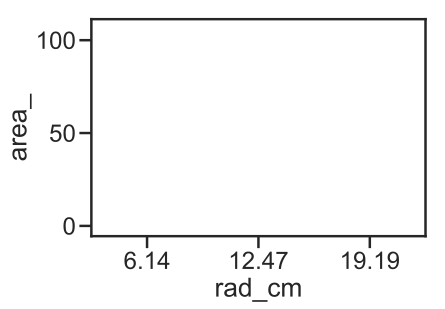

In [100]:
a,b=sinaplot2(x="rad_cm", y="area_", data=df_m, violin=False, point_size=3, palette=[c_tuning],
                      alpha=1, order=df_m.rad_cm.unique())

No handles with labels found to put in legend.


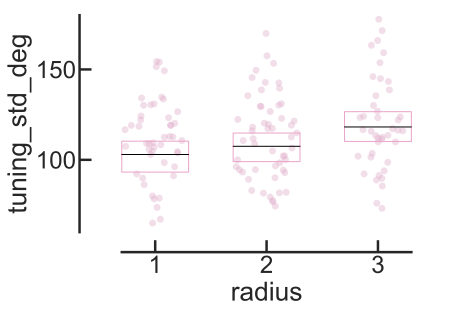

No handles with labels found to put in legend.


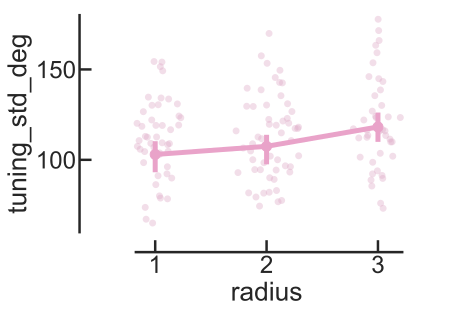

No handles with labels found to put in legend.


(60, 180)

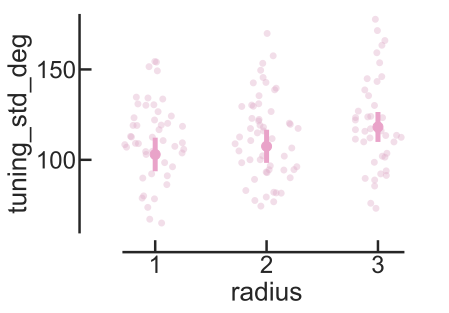

In [25]:

linares_plot(x='radius', y='tuning_std_deg', order=[1,2,3], CI=0.95,
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box=True, LW=5, MS=10, reps=1000)

plt.gca().set_ylim( 60,180)
plt.show()


linares_plot(x='radius', y='tuning_std_deg', order=[1,2,3], CI=0.95,
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=5, MS=10, reps=1000)

plt.gca().set_ylim( 60,180)
plt.show()


linares_plot(x='radius', y='tuning_std_deg', order=[1,2,3], CI=0.95,
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='mean', LW=5, MS=10, reps=1000)

plt.gca().set_ylim( 60,180)

In [24]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 28 12:26:52 2019

@author: David Bestue
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import scikits.bootstrap as bootstraps
from seaborn_sinaplot import sinaplot ## install at https://github.com/mparker2/seaborn_sinaplot
import numpy as np

### Style of poster for the plots
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")


def boots_by_subj(data, col_int, col_subj, n_iterations, alpha, stat):
    #### if I want to compare two curves, I would use a sem to check the overlapping of the curves, so a=0.32 (ci = 1-0.68)
    #### you give a 2 column df, one column qith the value and the other column with subject index:
    list_subjects = data[col_subj].unique()
    sample=[]
    for n in range(n_iterations):
        resampled=[]
        new_sample = list(np.random.randint(0, len(list_subjects), len(list_subjects)))
        for res_s in new_sample:
            resampled = resampled + list(data.loc[data[col_subj]==list_subjects[res_s], col_int].values) 
        #
        sample.append(stat(resampled))
    #
    stats_sorted = np.sort(sample)
    new_mean=np.mean(sample)
    return (new_mean, stats_sorted[int((alpha/2.0)*n_iterations)],
            stats_sorted[int((1-alpha/2.0)*n_iterations)])




def adjust_spines(ax, spines):  ### aesthetics, offset axies 
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])




def linares_plot(x, y, df, palette, order, hue=None, hue_order=None, point_size=1, alpha=0.4, CI=0.95,
                  width=0.6, statistic=np.mean, by_subj=False, subj_col=None, plot_box=True, MS=12, LW=4, reps=10000, leg=True):
    ####
    ####
    ####  This plots consists of a SINAPLOT (plot the trials/subjects) showing the distribution &
    ####  a BOX with the statistic (mean/median) and with the 95% c.i done by bootstrap.
    ####
    ####
    #### SINAPLOT
    if by_subj==True:                                                                                                           # sinaplpot: one point per subject
        if hue==None:                                                                                                           # hue for the sinaplot
            df_by_subj=[]
            for x_val in order:
                for s_subject in df[subj_col].unique():
                    val_subj = df.loc[(df[subj_col]==s_subject) & (df[x]==x_val), y].mean()
                    df_by_subj.append([x_val, val_subj])
            #
            df_by_subj = pd.DataFrame(df_by_subj)
            df_by_subj.columns=[x, y]
            df_by_subj = df_by_subj[~np.isnan(df_by_subj.iloc[:,1])]
            sinaplot.sinaplot(x=x, y=y, hue=hue, data=df_by_subj, violin=False, point_size=point_size, palette=palette, 
                alpha=alpha, order=order, hue_order=hue_order, width=width)

        else:                                                                                                                   #no hue for the sinaplot                                                             
            df_by_subj=[]
            for x_val in order:
                for h_val in hue_order:
                    for s_subject in df[subj_col].unique():
                        val_subj = df.loc[(df[subj_col]==s_subject) & (df[x]==x_val) & (df[hue]==h_val), y].mean()
                        df_by_subj.append([x_val, h_val, val_subj])
            #
            df_by_subj = pd.DataFrame(df_by_subj)
            df_by_subj.columns=[x, hue, y]
            df_by_subj = df_by_subj[~np.isnan(df_by_subj.iloc[:,2])]
            sinaplot.sinaplot(x=x, y=y, hue=hue, data=df_by_subj, violin=False, point_size=point_size, palette=palette, 
                alpha=alpha, order=order, hue_order=hue_order, width=width)

    else:                                                                                                                       # sinaplot: one point per trial (default)
        sinaplot.sinaplot(x=x, y=y, hue=hue, data=df, violin=False, point_size=point_size, palette=palette,
                      alpha=alpha, order=order, hue_order=hue_order, width=width)

    ##### BOX
    cis=[]
    stas_m = []
    if hue==None:                                                                                                               # Box with median and c.i 95%
        for i_x, x_idx in enumerate(order):
            if by_subj==True:
                df_boot_bysubj = pd.DataFrame({y: df.groupby(x).get_group(x_idx)[y], subj_col: df.groupby(x).get_group(x_idx)[subj_col]})
                new_mean, inf_b, sup_b = boots_by_subj(df_boot_bysubj, y, subj_col, n_iterations=reps, alpha=1-CI, stat=np.mean)
                ci= np.array([inf_b, sup_b])
                cis.append(ci)
            #
            else:
                ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
                cis.append(ci)
            ##
            ####                
            m= statistic( df.loc[df[x]==x_idx, y] ) 
            stas_m.append(m)
            if plot_box==True:
                # vallue statistic
                left =  i_x - width/2   #i_x - width/len(order)  
                if len(palette)>1:
                    # position of rectangle
                    plt.gca().add_patch(Rectangle((left, ci[0]), width, ci[1]-ci[0],alpha=1, fill=False, linewidth=1,  edgecolor=palette[i_x]))                 # plot the rectangle 
                    plt.plot([left, left+width], [m,m ], color='k', linewidth=1) 
                else:
                    plt.gca().add_patch(Rectangle((left, ci[0]), width, ci[1]-ci[0],alpha=1, fill=False, linewidth=1,  edgecolor=palette[0]))                 # plot the rectangle 
                    plt.plot([left, left+width], [m,m ], color='k', linewidth=1) 
    #        
    else:                                                                                                                       # hue
        for i_x, x_idx in enumerate(order):
            for i_h, h_idx in enumerate(hue_order):
                try:
                    if by_subj==True:
                        df_boot_bysubj = pd.DataFrame({y: df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[y], subj_col: df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[subj_col]})
                        new_mean, inf_b, sup_b = boots_by_subj(df_boot_bysubj, y, subj_col, n_iterations=reps, alpha=1-CI, stat=np.mean)
                        ci= np.array([inf_b, sup_b])
                        cis.append(ci)
                    else:
                        ci= bootstraps.ci(df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[y], statfunction=statistic,  alpha=1-CI, n_samples=reps)
                        cis.append(ci)
                    #
                    m= statistic( df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[y] )
                    stas_m.append(m)
                    if plot_box==True:
                        bar_length = width/len(hue_order) 
                        bott_left = i_x - width/2   + i_h*bar_length
                        plt.gca().add_patch(Rectangle((bott_left, ci[0]), bar_length , ci[1]-ci[0],
                                                      alpha=1, fill=False, linewidth=1, edgecolor=palette[i_h]))
                        plt.plot( [bott_left, bott_left+bar_length], [m,m ], palette[i_h], linewidth=3)
                    
                except:
                    IndexError
    
    if plot_box=='line':
        if hue == None:
            means_=stas_m
            cis_ =cis
            x_s = np.array(range(len(order)))
            errors_abs = [abs(cis_[x]-means_[x]) for x in range(len(order))]
            neg_errors = [errors_abs[x][0] for x in range(len(order))]
            pos_errors = [errors_abs[x][1] for x in range(len(order))]
            plt.plot(x_s, means_, marker='o', markersize=MS, color=palette[0])
            plt.errorbar(x_s, means_, yerr=[neg_errors, pos_errors], color=palette[0], linewidth=LW)
            
        else:
            for i_h, h_idx in enumerate(hue_order):
                means_hue=stas_m[i_h::(len(hue_order))]
                cis_hue = cis[i_h::(len(hue_order))] 
                biases_pos = np.arange(-0.1, 1, 0.2)
                bias_x = biases_pos[i_h]               
                x_s = np.array(range(len(order))) + bias_x
                errors_abs = [abs(cis_hue[x]-means_hue[x]) for x in range(len(order))]
                neg_errors = [errors_abs[x][0] for x in range(len(order))]
                pos_errors = [errors_abs[x][1] for x in range(len(order))]
                plt.plot(x_s, means_hue, marker='o', markersize=MS, color=palette[i_h])
                plt.errorbar(x_s, means_hue, yerr=[neg_errors, pos_errors], color=palette[i_h], linewidth=LW)
                #
    ##
    if plot_box=='mean':
        if hue == None:
            means_=stas_m
            cis_ =cis
            x_s = np.array(range(len(order)))
            errors_abs = [abs(cis_[x]-means_[x]) for x in range(len(order))]
            neg_errors = [errors_abs[x][0] for x in range(len(order))]
            pos_errors = [errors_abs[x][1] for x in range(len(order))]
            if len(palette)>1:
                [plt.plot(x_s[n], means_[n], marker='o', markersize=MS, color=palette[n], linewidth=0) for n in range(len(means_))]
                [plt.errorbar(x_s[n], means_[n], yerr=[[neg_errors[n], pos_errors[n] ]], color=palette[n], 
                    linewidth=0, elinewidth=LW ) for n in range(len(means_))]
            else:
                [plt.plot(x_s[n], means_[n], marker='o', markersize=MS, color=palette[0], linewidth=0) for n in range(len(means_))]
                [plt.errorbar(x_s[n], means_[n], yerr=[[neg_errors[n], pos_errors[n] ]], color=palette[0], 
                    linewidth=0, elinewidth=LW ) for n in range(len(means_))]
            
        else:
            for i_h, h_idx in enumerate(hue_order):
                means_hue=stas_m[i_h::(len(hue_order))]
                cis_hue = cis[i_h::(len(hue_order))] 
                biases_pos = np.arange(-0.1, 1, 0.2)
                bias_x = biases_pos[i_h]               
                x_s = np.array(range(len(order))) + bias_x
                errors_abs = [abs(cis_hue[x]-means_hue[x]) for x in range(len(order))]
                neg_errors = [errors_abs[x][0] for x in range(len(order))]
                pos_errors = [errors_abs[x][1] for x in range(len(order))]
                plt.plot(x_s, means_hue, marker='o', markersize=MS, color=palette[i_h], linewidth=0)
                plt.errorbar(x_s, means_hue, yerr=[neg_errors, pos_errors], color=palette[i_h], 
                    linewidth=0, elinewidth=LW)
                
            
        
    
    
    plt.xticks(  np.arange(len(df[x].unique())) , order)                                                                        # Aesthetics of the plot
    plt.xlim(-0.5, len(df[x].unique())-0.5 )                                                                                    # xlim
    plt.gca().spines['right'].set_visible(False)  ## aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    adjust_spines(plt.gca(), ['left', 'bottom'])
    ## Legend
    if leg==True:
        l = plt.legend(loc='best', frameon=False, prop={'size': 16})
    #l.get_texts()[0].set_text('delay=0')
    



